# NYC Traffic Collision Analysis and Modeling

### Authors: Ned Kost, Pawan Tahiliani, Anova Youngers

### Date:  10/22/2023


Below is an analysis of Motor Vehicle Collisions in New York City, based on a dataset provide through kaggle.com (https://www.kaggle.com/datasets/tush32/motor-vehicle-collisions-crashes/data), and licensed by the U.S. Government Works. Each data row represents a single accident with attributes collected by the police whenever an accident involved an injury, fatality, or property damage in excess of $1,000.

Our goal for this project is to perform statistical analysis and modeling with this data to identify recommendations for New York that can reduce injuries and fatalities.


### Data Loading and Cleaning

In [3]:
# Import libraries used throughout the project
import pandas as pd
import numpy as np
import math
import datetime
from datetime import datetime
import matplotlib.pyplot as plt
import warnings
import statsmodels.api as sm
import seaborn as sns
import scipy.stats as stats
from scipy.stats import chi2_contingency
from statsmodels.graphics.mosaicplot import mosaic
from matplotlib.pyplot import figure
from matplotlib import gridspec
from sklearn.model_selection import train_test_split
from datetime import datetime
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import PoissonRegressor
from sklearn.metrics import roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score

# Turn off Warnings
warnings.filterwarnings("ignore")

In [4]:
# Read in full Motor Vehicle Collision Dataset
mvc_df = pd.read_csv("Motor_Vehicle_Collisions_-_Crashes.csv")

# Output Column Names and Data Types
mvc_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2026647 entries, 0 to 2026646
Data columns (total 29 columns):
 #   Column                         Dtype  
---  ------                         -----  
 0   CRASH DATE                     object 
 1   CRASH TIME                     object 
 2   BOROUGH                        object 
 3   ZIP CODE                       object 
 4   LATITUDE                       float64
 5   LONGITUDE                      float64
 6   LOCATION                       object 
 7   ON STREET NAME                 object 
 8   CROSS STREET NAME              object 
 9   OFF STREET NAME                object 
 10  NUMBER OF PERSONS INJURED      float64
 11  NUMBER OF PERSONS KILLED       float64
 12  NUMBER OF PEDESTRIANS INJURED  int64  
 13  NUMBER OF PEDESTRIANS KILLED   int64  
 14  NUMBER OF CYCLIST INJURED      int64  
 15  NUMBER OF CYCLIST KILLED       int64  
 16  NUMBER OF MOTORIST INJURED     int64  
 17  NUMBER OF MOTORIST KILLED      int64  
 18  CO

In [5]:
# Function for finding the number of vehicles invovled in the collission
def num_vehicles_invovled(x):
    if(pd.isna(x['CONTRIBUTING FACTOR VEHICLE 2'])== True):
        return 1
    if(pd.isna(x['CONTRIBUTING FACTOR VEHICLE 2']) == False and pd.isna(x['CONTRIBUTING FACTOR VEHICLE 3']) == True):
        return 2
    if(pd.isna(x['CONTRIBUTING FACTOR VEHICLE 3']) == False and pd.isna(x['CONTRIBUTING FACTOR VEHICLE 4']) == True):
        return 3
    if(pd.isna(x['CONTRIBUTING FACTOR VEHICLE 4']) == False and pd.isna(x['CONTRIBUTING FACTOR VEHICLE 5']) == True):
        return 4
    if(pd.isna(x['CONTRIBUTING FACTOR VEHICLE 5']) == False):
        return 5

# Strip/Trim the columns
mvc_df.replace("(^\s+|\s+$)", "", regex=True, inplace=True)

# Add Column identifying YEAR
mvc_df['YEAR'] = mvc_df['CRASH DATE'].apply(lambda x: datetime.strptime(x, '%m/%d/%Y').year)

# To make the dataset more manageable, filter to only use the last 5 years of data
mvc_df = mvc_df[mvc_df['YEAR'] > 2018]

# Cleanup NA data:
#     Assume no Injuries or Fatalities if none were recorded. 
#     Fill missing Borough as Unknown
mvc_df['NUMBER OF PERSONS INJURED'].fillna(0, inplace=True)
mvc_df['NUMBER OF PERSONS KILLED'].fillna(0, inplace=True)
mvc_df['NUMBER OF PEDESTRIANS INJURED'].fillna(0, inplace=True)
mvc_df['NUMBER OF PEDESTRIANS KILLED'].fillna(0, inplace=True)
mvc_df['NUMBER OF CYCLIST INJURED'].fillna(0, inplace=True)
mvc_df['NUMBER OF CYCLIST KILLED'].fillna(0, inplace=True)
mvc_df['NUMBER OF MOTORIST INJURED'].fillna(0, inplace=True)
mvc_df['NUMBER OF MOTORIST KILLED'].fillna(0, inplace=True)
mvc_df['BOROUGH'].fillna('UNKNOWN', inplace=True)

# Add Columns for Crash Date, Crash Hour, and Day of the Week when the crash occurred
mvc_df['CRASH DATE'] = pd.to_datetime(mvc_df['CRASH DATE'])
mvc_df['CRASH HOUR'] = pd.to_datetime(mvc_df['CRASH TIME']).dt.hour
mvc_df['DAY OF WEEK'] = mvc_df['CRASH DATE'].dt.day_of_week
mvc_df["CRASH TIME"] = pd.to_datetime(mvc_df["CRASH TIME"])
mvc_df["CRASH TIME"] = pd.to_datetime(mvc_df["CRASH TIME"], format="%H:%M:%S").apply(pd.Timestamp)
mvc_df['CRASH MONTH'] = mvc_df['CRASH DATE'].dt.month
mvc_df['CRASH HOUR CONT'] = pd.to_datetime(mvc_df['CRASH TIME']).dt.hour + (pd.to_datetime(mvc_df['CRASH TIME']).dt.minute / 60)

# Create new Column for number of cars involved in crash
mvc_df['CARS INVOLVED'] = mvc_df.apply(lambda x: num_vehicles_invovled(x), axis=1)

# Add Columns representing if a collission resulted in Injury or Fatality, and sum of Injuries and Fatalities
mvc_df['HAS INJURY'] = mvc_df['NUMBER OF PERSONS INJURED'].apply(lambda x: 1 if (x > 0) else 0)
mvc_df['HAS FATALITY'] = mvc_df['NUMBER OF PERSONS KILLED'].apply(lambda x: 1 if (x > 0) else 0)
mvc_df['INJURY AND FATALITY'] = mvc_df['NUMBER OF PERSONS INJURED'] + mvc_df['NUMBER OF PERSONS KILLED']

##  TODO  --  DROP CRASH DATE?
# Drop Columns not used for this analysis, and create a cleaned DF to perform analysis
mvc_cleaned_df = mvc_df.drop(['ZIP CODE', 'LATITUDE', 'LONGITUDE', 'LOCATION', 'ON STREET NAME', 'CROSS STREET NAME', 'OFF STREET NAME', 'COLLISION_ID'], axis=1)
mvc_cleaned_df.head()

,CRASH DATE,CRASH TIME,BOROUGH,NUMBER OF PERSONS INJURED,NUMBER OF PERSONS KILLED,NUMBER OF PEDESTRIANS INJURED,NUMBER OF PEDESTRIANS KILLED,NUMBER OF CYCLIST INJURED,NUMBER OF CYCLIST KILLED,NUMBER OF MOTORIST INJURED,...,VEHICLE TYPE CODE 5,YEAR,CRASH HOUR,DAY OF WEEK,CRASH MONTH,CRASH HOUR CONT,CARS INVOLVED,HAS INJURY,HAS FATALITY,INJURY AND FATALITY
0,2021-09-11,2023-10-18 02:39:00,UNKNOWN,2.0,0.0,0,0,0,0,2,...,NaN,2021,2,5,9,2.650000,2,1,0,2.0
1,2022-03-26,2023-10-18 11:45:00,UNKNOWN,1.0,0.0,0,0,0,0,1,...,NaN,2022,11,5,3,11.750000,1,1,0,1.0
2,2022-06-29,2023-10-18 06:55:00,UNKNOWN,0.0,0.0,0,0,0,0,0,...,NaN,2022,6,2,6,6.916667,2,0,0,0.0
3,2021-09-11,2023-10-18 09:35:00,BROOKLYN,0.0,0.0,0,0,0,0,0,...,NaN,2021,9,5,9,9.583333,1,0,0,0.0
4,2021-12-14,2023-10-18 08:13:00,BROOKLYN,0.0,0.0,0,0,0,0,0,...,NaN,2021,8,1,12,8.216667,1,0,0,0.0


In [6]:
# Print Info about dataset
mvc_cleaned_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 606233 entries, 0 to 2026646
Data columns (total 30 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   CRASH DATE                     606233 non-null  datetime64[ns]
 1   CRASH TIME                     606233 non-null  datetime64[ns]
 2   BOROUGH                        606233 non-null  object        
 3   NUMBER OF PERSONS INJURED      606233 non-null  float64       
 4   NUMBER OF PERSONS KILLED       606233 non-null  float64       
 5   NUMBER OF PEDESTRIANS INJURED  606233 non-null  int64         
 6   NUMBER OF PEDESTRIANS KILLED   606233 non-null  int64         
 7   NUMBER OF CYCLIST INJURED      606233 non-null  int64         
 8   NUMBER OF CYCLIST KILLED       606233 non-null  int64         
 9   NUMBER OF MOTORIST INJURED     606233 non-null  int64         
 10  NUMBER OF MOTORIST KILLED      606233 non-null  int64         
 11  CONT

In [7]:
# Import Mapping Files to simplify Categorical data
causation_mapping_df = pd.read_csv('causation_factor_mapping_file.csv')
vechicle_mapping_df = pd.read_csv('vehicle_type_mapping_file.csv')

# Function to use for returning the category of a value
def map_to_category(value, mapping_df, lookup):
    if (pd.isna(value) == True):
        return'Unknown'
    category = mapping_df[mapping_df[lookup] == value]['Category']
    if(len(category) == 0):
        return 'Unknown'
    return category.values[0]

# Populate na Vehicle Codes as Unknown
mvc_cleaned_df['VEHICLE TYPE CODE 1'].fillna('Unknown', inplace=True)
mvc_cleaned_df['VEHICLE TYPE CODE 2'].fillna('Unknown', inplace=True)
mvc_cleaned_df['VEHICLE TYPE CODE 3'].fillna('Unknown', inplace=True)
mvc_cleaned_df['VEHICLE TYPE CODE 4'].fillna('Unknown', inplace=True)
mvc_cleaned_df['VEHICLE TYPE CODE 5'].fillna('Unknown', inplace=True)

# Categorize Cause Factor for each Vehicle
mvc_cleaned_df['CAUSE CATEGORY 1'] = mvc_cleaned_df['CONTRIBUTING FACTOR VEHICLE 1'].apply(lambda x: map_to_category(x, causation_mapping_df, 'Causation Factor'))
mvc_cleaned_df['CAUSE CATEGORY 2'] = mvc_cleaned_df['CONTRIBUTING FACTOR VEHICLE 2'].apply(lambda x: map_to_category(x, causation_mapping_df, 'Causation Factor'))
mvc_cleaned_df['CAUSE CATEGORY 3'] = mvc_cleaned_df['CONTRIBUTING FACTOR VEHICLE 3'].apply(lambda x: map_to_category(x, causation_mapping_df, 'Causation Factor'))
mvc_cleaned_df['CAUSE CATEGORY 4'] = mvc_cleaned_df['CONTRIBUTING FACTOR VEHICLE 4'].apply(lambda x: map_to_category(x, causation_mapping_df, 'Causation Factor'))
mvc_cleaned_df['CAUSE CATEGORY 5'] = mvc_cleaned_df['CONTRIBUTING FACTOR VEHICLE 5'].apply(lambda x: map_to_category(x, causation_mapping_df, 'Causation Factor'))

# Categorize Vehicle Type for each Vehicle
mvc_cleaned_df['VEHICLE CATEGORY 1'] = mvc_cleaned_df['VEHICLE TYPE CODE 1'].apply(lambda x:map_to_category(x.lower(), vechicle_mapping_df, 'Vehicle Type'))
mvc_cleaned_df['VEHICLE CATEGORY 2'] = mvc_cleaned_df['VEHICLE TYPE CODE 2'].apply(lambda x:map_to_category(x.lower(), vechicle_mapping_df, 'Vehicle Type'))
mvc_cleaned_df['VEHICLE CATEGORY 3'] = mvc_cleaned_df['VEHICLE TYPE CODE 3'].apply(lambda x:map_to_category(x.lower(), vechicle_mapping_df, 'Vehicle Type'))
mvc_cleaned_df['VEHICLE CATEGORY 4'] = mvc_cleaned_df['VEHICLE TYPE CODE 4'].apply(lambda x:map_to_category(x.lower(), vechicle_mapping_df, 'Vehicle Type'))
mvc_cleaned_df['VEHICLE CATEGORY 5'] = mvc_cleaned_df['VEHICLE TYPE CODE 5'].apply(lambda x:map_to_category(x.lower(), vechicle_mapping_df, 'Vehicle Type'))
mvc_cleaned_df.head()


,CRASH DATE,CRASH TIME,BOROUGH,NUMBER OF PERSONS INJURED,NUMBER OF PERSONS KILLED,NUMBER OF PEDESTRIANS INJURED,NUMBER OF PEDESTRIANS KILLED,NUMBER OF CYCLIST INJURED,NUMBER OF CYCLIST KILLED,NUMBER OF MOTORIST INJURED,...,CAUSE CATEGORY 1,CAUSE CATEGORY 2,CAUSE CATEGORY 3,CAUSE CATEGORY 4,CAUSE CATEGORY 5,VEHICLE CATEGORY 1,VEHICLE CATEGORY 2,VEHICLE CATEGORY 3,VEHICLE CATEGORY 4,VEHICLE CATEGORY 5
0,2021-09-11,2023-10-18 02:39:00,UNKNOWN,2.0,0.0,0,0,0,0,2,...,Traffic Rules,Unknown,Unknown,Unknown,Unknown,Car,Car,Unknown,Unknown,Unknown
1,2022-03-26,2023-10-18 11:45:00,UNKNOWN,1.0,0.0,0,0,0,0,1,...,Nature,Unknown,Unknown,Unknown,Unknown,Car,Unknown,Unknown,Unknown,Unknown
2,2022-06-29,2023-10-18 06:55:00,UNKNOWN,0.0,0.0,0,0,0,0,0,...,Traffic Rules,Unknown,Unknown,Unknown,Unknown,Car,Truck,Unknown,Unknown,Unknown
3,2021-09-11,2023-10-18 09:35:00,BROOKLYN,0.0,0.0,0,0,0,0,0,...,Unknown,Unknown,Unknown,Unknown,Unknown,Car,Unknown,Unknown,Unknown,Unknown
4,2021-12-14,2023-10-18 08:13:00,BROOKLYN,0.0,0.0,0,0,0,0,0,...,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown


### Data Analysis - Injuries and Fatalities

In [8]:

coll_by_year = mvc_cleaned_df.groupby('YEAR').agg({'CRASH DATE': 'count', 'NUMBER OF PERSONS INJURED': 'sum', 
                                                   'NUMBER OF PERSONS KILLED': 'sum', 'INJURY AND FATALITY': 'sum'})
coll_by_year = coll_by_year.rename(columns={'CRASH DATE': 'COLLISION COUNT', 'NUMBER OF PERSONS INJURED': 'INJURY', 
                           'NUMBER OF PERSONS KILLED': 'FATALITY'})

coll_by_year['INJURY RATE'] = round((coll_by_year['INJURY'] / coll_by_year['COLLISION COUNT'])*100, 2)
coll_by_year['FATALITY RATE'] = round((coll_by_year['FATALITY'] / coll_by_year['COLLISION COUNT'])*100, 2)
coll_by_year['COMBINED RATE'] = round((coll_by_year['INJURY AND FATALITY'] / coll_by_year['COLLISION COUNT'])*100,2)
display(coll_by_year.loc[:,['INJURY RATE', 'FATALITY RATE', 'COMBINED RATE']])



,INJURY RATE,FATALITY RATE,COMBINED RATE
YEAR,,,
2019,29.03,0.12,29.14
2020,39.51,0.24,39.75
2021,46.84,0.27,47.11
2022,49.99,0.28,50.27
2023,55.71,0.27,55.97


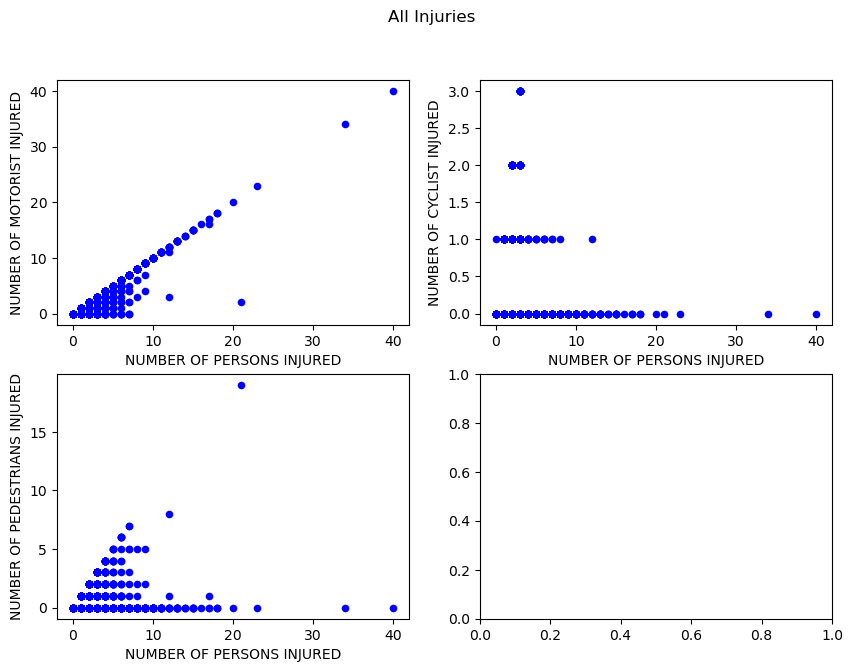

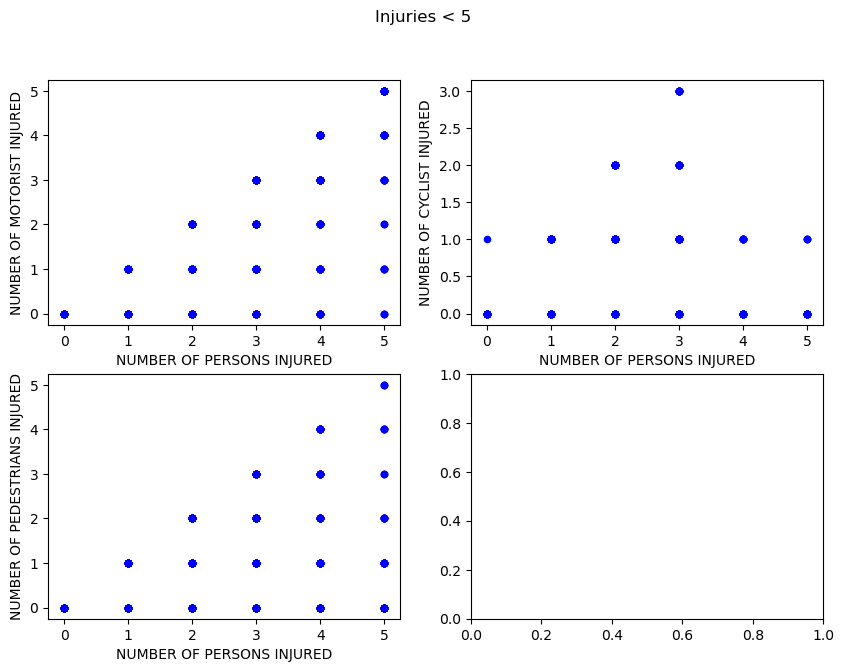

In [9]:
# Prepare space for graphs
fig, ax = plt.subplots(2, 2)

# Scatterplot of Number of Motorists Injured against Number of Persons Injured
mvc_cleaned_df.plot(
    kind="scatter",
    y="NUMBER OF MOTORIST INJURED",
    x="NUMBER OF PERSONS INJURED",
    color="blue",
    figsize=(10, 7),
    ax=ax[0][0],
)

# Scatterplot of Number of Pedestrians Injured against Number of Persons Injured
mvc_cleaned_df.plot(
    kind="scatter",
    y="NUMBER OF PEDESTRIANS INJURED",
    x="NUMBER OF PERSONS INJURED",
    color="blue",
    figsize=(10, 7),
    ax=ax[1][0],
)

# Scatterplot of Number of Cyclists Injured against Number of Persons Injured
mvc_cleaned_df.plot(
    kind="scatter",
    y="NUMBER OF CYCLIST INJURED",
    x="NUMBER OF PERSONS INJURED",
    color="blue",
    figsize=(10, 7),
    ax=ax[0][1],
)

# Add Title and Output Graphs
fig.suptitle("All Injuries")
plt.show()

# Prepare space for graphs
fig, ax = plt.subplots(2, 2)

# Filter dataset to only find accidents with less than 5 people injured
less_than_5_injured = mvc_cleaned_df[mvc_cleaned_df["NUMBER OF PERSONS INJURED"] <= 5]

# Scatterplot of Number of Motorists Injured against Number of Persons Injured
less_than_5_injured.plot(
    kind="scatter",
    y="NUMBER OF MOTORIST INJURED",
    x="NUMBER OF PERSONS INJURED",
    color="blue",
    figsize=(10, 7),
    ax=ax[0][0],
)
# Scatterplot of Number of Pedestrians Injured against Number of Persons Injured
less_than_5_injured.plot(
    kind="scatter",
    y="NUMBER OF PEDESTRIANS INJURED",
    x="NUMBER OF PERSONS INJURED",
    color="blue",
    figsize=(10, 7),
    ax=ax[1][0],
)
# Scatterplot of Number of Cyclists Injured against Number of Persons Injured
less_than_5_injured.plot(
    kind="scatter",
    y="NUMBER OF CYCLIST INJURED",
    x="NUMBER OF PERSONS INJURED",
    color="blue",
    figsize=(10, 7),
    ax=ax[0][1],
)

# Add Title and Output Graphs
fig.suptitle("Injuries < 5")
plt.show()

### Data Analysis - Time

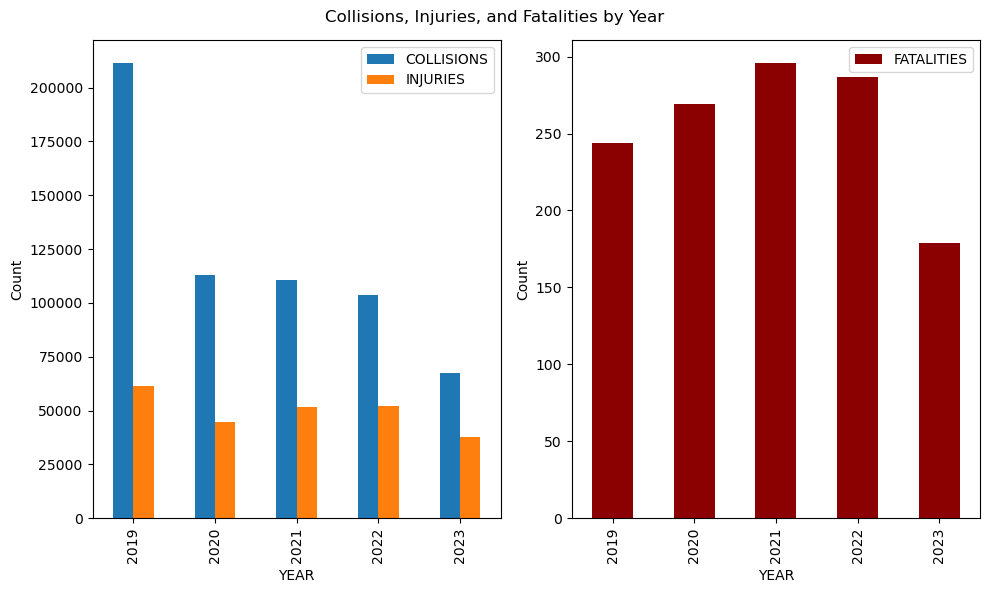

In [10]:
# Yearly trends
yearly_trends_df = mvc_cleaned_df.groupby('YEAR').agg({'CRASH HOUR': 'count', 'NUMBER OF PERSONS INJURED': 'sum', 'NUMBER OF PERSONS KILLED': 'sum'})
yearly_trends_df.rename(columns={'CRASH HOUR': 'COLLISIONS', 'NUMBER OF PERSONS INJURED': 'INJURIES', 'NUMBER OF PERSONS KILLED': 'FATALITIES'}, inplace=True)
yearly_trends_df.reset_index(drop = False, inplace=True)
yearly_trends_df.head()

# Define the Grid layout that will hold the graph plots
gs = gridspec.GridSpec(1,2)
fig = plt.figure(figsize=(10,6))

# Create sub-plots for the 2 graphs
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])

# Create Bar Graphs to show Count of Collisions and people Injured or Killed
yearly_trends_df.plot(x='YEAR', y=['COLLISIONS', 'INJURIES'], ax=ax1, kind='bar')
yearly_trends_df.plot(x='YEAR', y='FATALITIES', ax=ax2, kind='bar', color='darkred')

# Add Labels
ax1.set_ylabel('Count')
ax2.set_ylabel('Count')

# Pretty up the graphs
fig.tight_layout()
fig.supylabel('')
fig.supxlabel('')
fig.suptitle('Collisions, Injuries, and Fatalities by Year')
fig.subplots_adjust(top=.93)
plt.show()


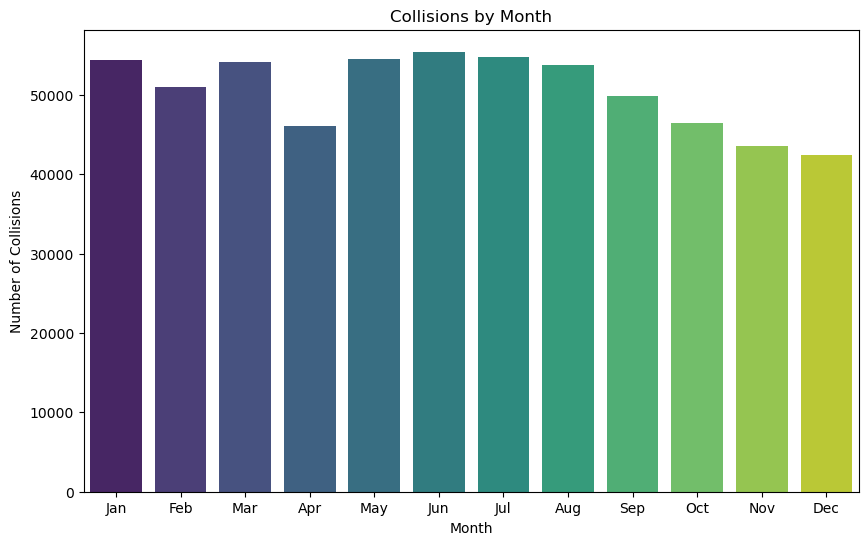

In [11]:
# Graph Collisions by Month
plt.figure(figsize=(10, 6))
sns.countplot(data=mvc_cleaned_df, x='CRASH MONTH', palette="viridis")
plt.title('Collisions by Month')
plt.ylabel('Number of Collisions')
plt.xlabel('Month')
plt.xticks(ticks=range(12), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.show()


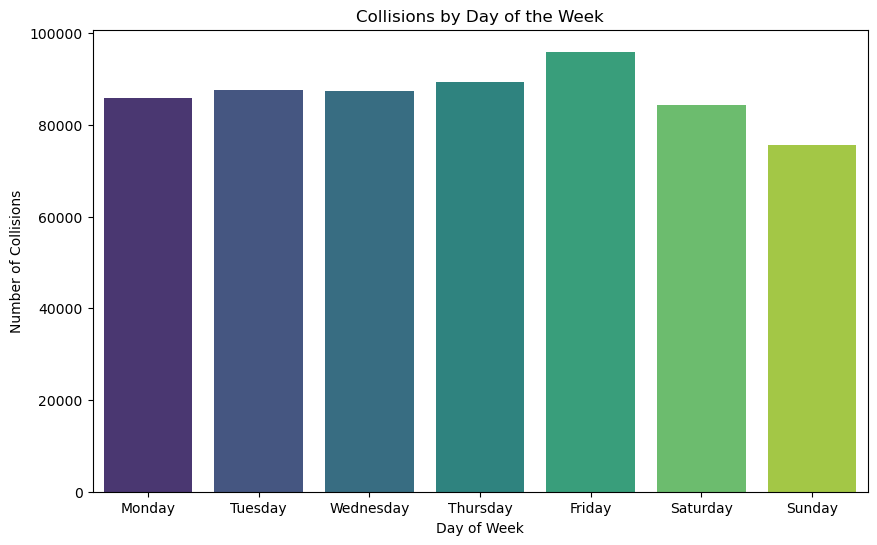

In [12]:
# Plot Collisions by Day of Week
plt.figure(figsize=(10, 6))
sns.countplot(data=mvc_cleaned_df, x='DAY OF WEEK', palette="viridis")
plt.title('Collisions by Day of the Week')
plt.ylabel('Number of Collisions')
plt.xlabel('Day of Week')
plt.xticks(ticks=range(7), labels=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.show()


### Data Analysis - Borough

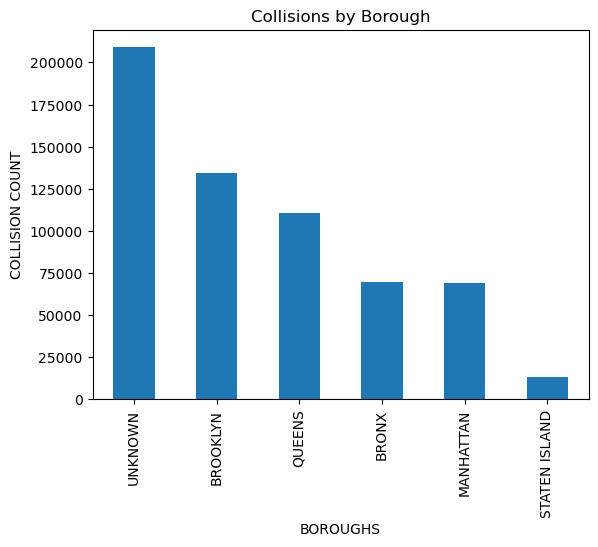

In [13]:
# Split into boroughs and describe
MVC_Brooklyn = mvc_cleaned_df[mvc_cleaned_df["BOROUGH"] == "BROOKLYN"]
MVC_Manhattan = mvc_cleaned_df[mvc_cleaned_df["BOROUGH"] == "MANHATTAN"]
MVC_Queens = mvc_cleaned_df[mvc_cleaned_df["BOROUGH"] == "QUEENS"]
MVC_Bronx = mvc_cleaned_df[mvc_cleaned_df["BOROUGH"] == "BRONX"]
MVC_StatenIsland = mvc_cleaned_df[mvc_cleaned_df["BOROUGH"] == "STATEN ISLAND"]

# Output Bargraph of Collisions by Borough
mvc_cleaned_df["BOROUGH"].value_counts().plot.bar()
plt.xlabel('BOROUGHS')
plt.ylabel('COLLISION COUNT')
plt.title('Collisions by Borough')
plt.show()

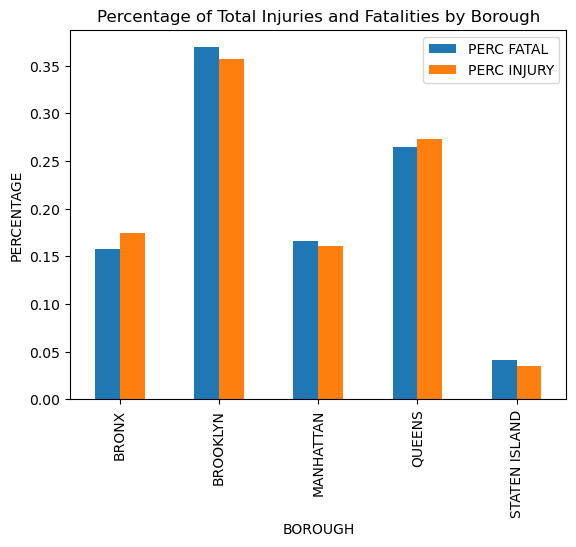

In [14]:
# Retrieve Deaths and Injuries for all Boroughs
MVC_HasDeath = mvc_cleaned_df[(mvc_cleaned_df["HAS FATALITY"] == 1) & (mvc_cleaned_df['BOROUGH'] != 'UNKNOWN')]
MVC_HasInjury = mvc_cleaned_df[(mvc_cleaned_df["HAS INJURY"] == 1) & (mvc_cleaned_df['BOROUGH'] != 'UNKNOWN')]

# Calculate proportion of Injury or Fatality based on Burough
Borough_DeathPerc= MVC_HasDeath.groupby("BOROUGH")['HAS FATALITY'].count()/len(MVC_HasDeath)
Borough_InjuryPerc= MVC_HasInjury.groupby("BOROUGH")['HAS INJURY'].count()/len(MVC_HasInjury)
Borough_Names = list(MVC_HasInjury.groupby("BOROUGH")['HAS INJURY'].count().index)

# Put calculations into a Dataframe for graphing
Borough_InjuryDeathPerc = pd.DataFrame({'BOROUGH':Borough_Names,
                                        'PERC FATAL': Borough_DeathPerc,
                                        'PERC INJURY': Borough_InjuryPerc})
# Graph What Percentages Injuries or Deaths occur in each Borough
Borough_InjuryDeathPerc.plot(x='BOROUGH', y=['PERC FATAL', 'PERC INJURY'], kind='bar')
plt.ylabel('PERCENTAGE')
plt.title('Percentage of Total Injuries and Fatalities by Borough')
plt.show()


In [42]:
def crashContToTime (x):
    m, h = math.modf(x)
    m = int(m * 60)
    h = int(h)
    s = 0
    t=datetime.time(hour=h,minute=m,second=s)
    return t

MVC_Queens['CRASH HOUR CONT'] = np.where(MVC_Queens['CRASH HOUR CONT'] < 1, MVC_Queens['CRASH HOUR CONT'] + 24, MVC_Queens['CRASH HOUR CONT'])
MVC_Bronx['CRASH HOUR CONT'] = np.where(MVC_Bronx['CRASH HOUR CONT'] < 1, MVC_Bronx['CRASH HOUR CONT'] + 24, MVC_Bronx['CRASH HOUR CONT'])
MVC_Manhattan['CRASH HOUR CONT'] = np.where(MVC_Manhattan['CRASH HOUR CONT'] < 1, MVC_Manhattan['CRASH HOUR CONT'] + 24, MVC_Manhattan['CRASH HOUR CONT'])
MVC_StatenIsland['CRASH HOUR CONT'] = np.where(MVC_StatenIsland['CRASH HOUR CONT'] < 1, MVC_StatenIsland['CRASH HOUR CONT'] + 24, MVC_StatenIsland['CRASH HOUR CONT'])
MVC_Brooklyn['CRASH HOUR CONT'] = np.where(MVC_Brooklyn['CRASH HOUR CONT'] < 1, MVC_Brooklyn['CRASH HOUR CONT'] + 24, MVC_Brooklyn['CRASH HOUR CONT'])

print("Queens Mean = {}, Std = {}".format(crashContToTime(np.mean(MVC_Queens['CRASH HOUR CONT'])), crashContToTime(np.std(MVC_Queens['CRASH HOUR CONT']))))
print("Bronx Mean = {}, Std = {}".format(crashContToTime(np.mean(MVC_Bronx['CRASH HOUR CONT'])), crashContToTime(np.std(MVC_Bronx['CRASH HOUR CONT']))))
print("Manhattan Mean = {}, Std = {}".format(crashContToTime(np.mean(MVC_Manhattan['CRASH HOUR CONT'])), crashContToTime(np.std(MVC_Manhattan['CRASH HOUR CONT'])))) 
print("Staten Island Mean = {}, Std = {}".format(crashContToTime(np.mean(MVC_StatenIsland['CRASH HOUR CONT'])), crashContToTime(np.std(MVC_StatenIsland['CRASH HOUR CONT']))))
print("Brooklyn Mean = {}, Std = {}".format(crashContToTime(np.mean(MVC_Brooklyn['CRASH HOUR CONT'])), crashContToTime(np.std(MVC_Brooklyn['CRASH HOUR CONT']))))
    

Queens Mean = 14:15:00, Std = 05:45:00
Bronx Mean = 14:20:00, Std = 05:44:00
Manhattan Mean = 14:25:00, Std = 05:44:00
Staten Island Mean = 14:35:00, Std = 05:33:00
Brooklyn Mean = 14:30:00, Std = 05:37:00


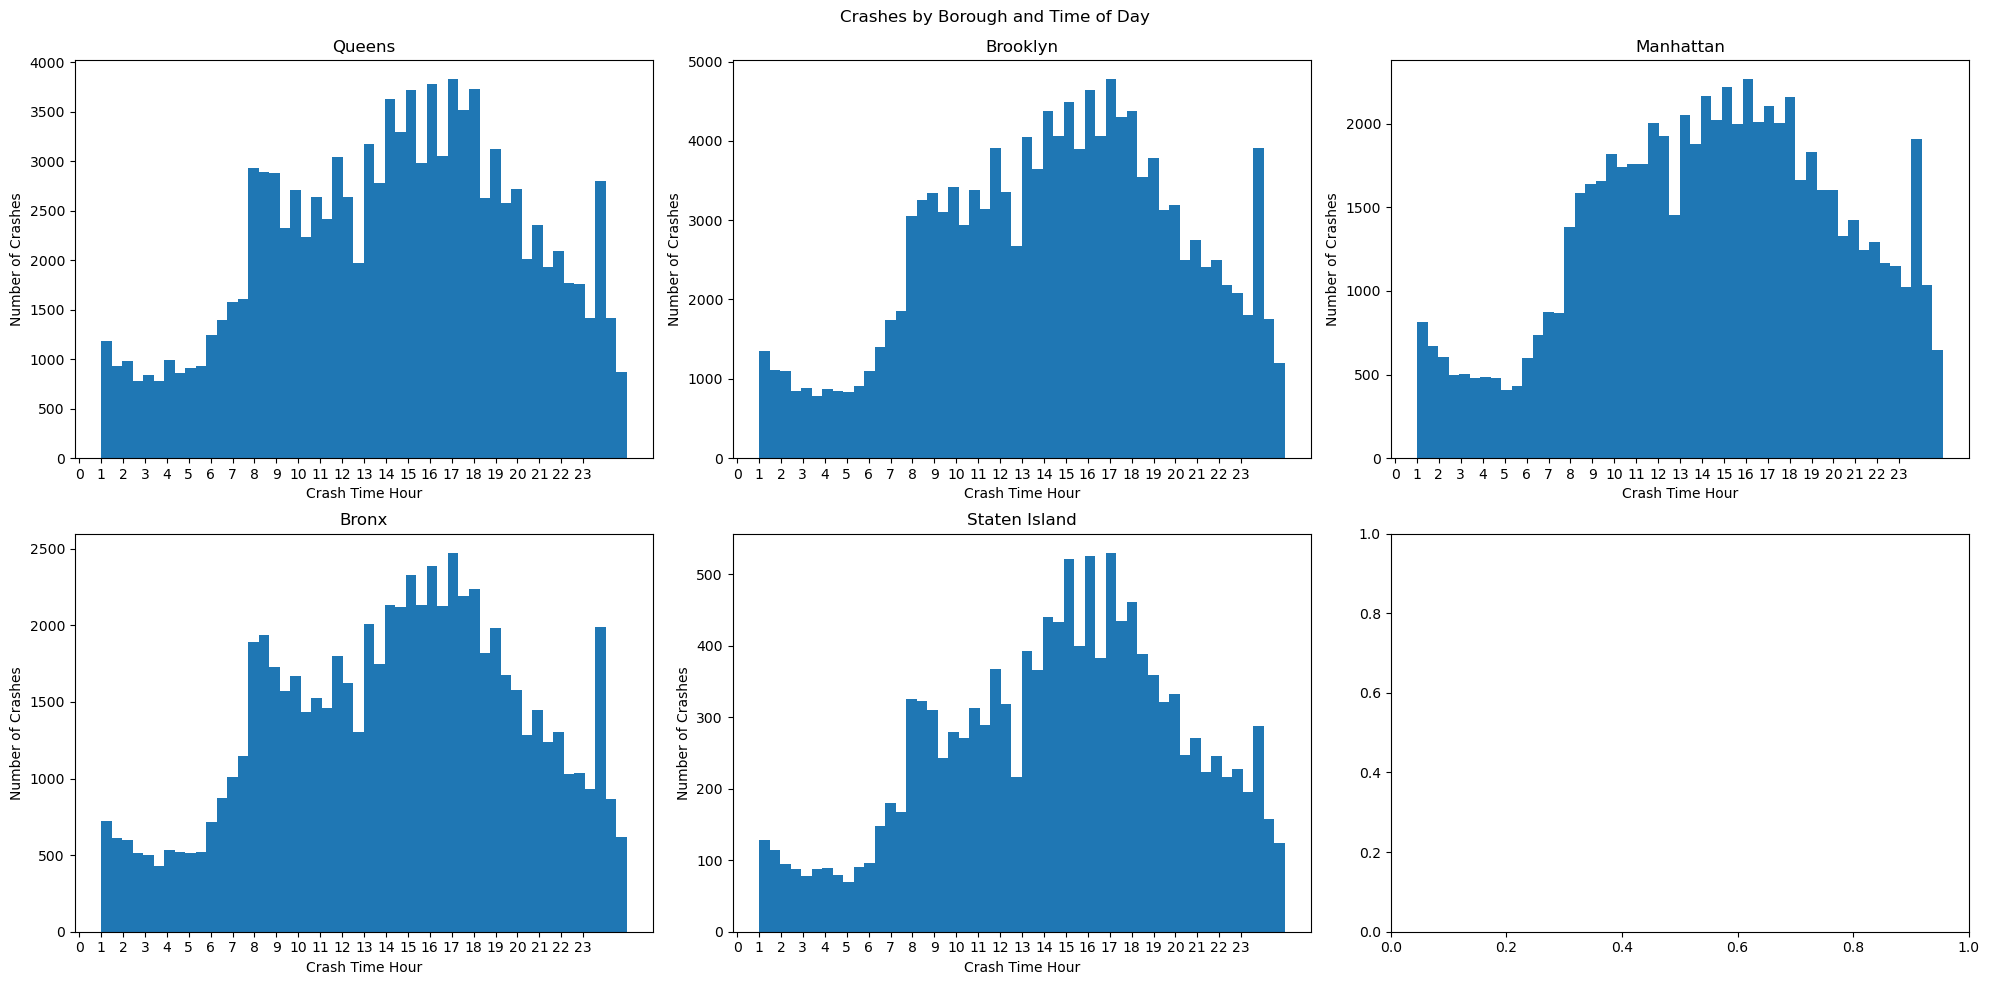

In [43]:
# Create space for SubPlots
fig, axs = plt.subplots(2, 3, figsize=(20, 10))

# Plot Crashes per Hour in Queens
axs[0][0].hist(MVC_Queens["CRASH HOUR CONT"], bins=50)
axs[0][0].set_xticks(np.arange(0, 24))
axs[0][0].set_xlabel("Crash Time Hour")
axs[0][0].set_ylabel("Number of Crashes")
axs[0][0].set_title("Queens")

# Plot Crashes per Hour in Brooklyn
axs[0][1].hist(MVC_Brooklyn["CRASH HOUR CONT"], bins=50)
axs[0][1].set_xticks(np.arange(0, 24))
axs[0][1].set_xlabel("Crash Time Hour")
axs[0][1].set_ylabel("Number of Crashes")
axs[0][1].set_title("Brooklyn")

# Plot Crashes per Hour in Manhattan
axs[0][2].hist(MVC_Manhattan["CRASH HOUR CONT"], bins=50)
axs[0][2].set_xticks(np.arange(0, 24))
axs[0][2].set_xlabel("Crash Time Hour")
axs[0][2].set_ylabel("Number of Crashes")
axs[0][2].set_title("Manhattan")

# Plot Crashes per Hour in Bronx
axs[1][0].hist(MVC_Bronx["CRASH HOUR CONT"], bins=50)
axs[1][0].set_xticks(np.arange(0, 24))
axs[1][0].set_xlabel("Crash Time Hour")
axs[1][0].set_ylabel("Number of Crashes")
axs[1][0].set_title("Bronx")

# Plot Crashes per Hour in StatenIsland
axs[1][1].hist(MVC_StatenIsland["CRASH HOUR CONT"], bins=50)
axs[1][1].set_xticks(np.arange(0, 24))
axs[1][1].set_xlabel("Crash Time Hour")
axs[1][1].set_ylabel("Number of Crashes")
axs[1][1].set_title("Staten Island")

# Pretty up the graphs
fig.tight_layout()
fig.supylabel('')
fig.supxlabel('')
fig.suptitle('Crashes by Borough and Time of Day')
fig.subplots_adjust(top=.93)
plt.show()

In [16]:
f_stat, p_value = stats.f_oneway(MVC_StatenIsland["CRASH HOUR CONT"], MVC_Bronx["CRASH HOUR CONT"], MVC_Manhattan["CRASH HOUR CONT"], MVC_Brooklyn["CRASH HOUR CONT"], MVC_Queens["CRASH HOUR CONT"])
print('There is a statistical difference between Boroughs and crash times.')
print('F-stat: %.2f' % f_stat, 'P-value: %.2f ' % p_value)

f_stat, p_value = stats.f_oneway(MVC_StatenIsland["INJURY AND FATALITY"], MVC_Bronx["INJURY AND FATALITY"], MVC_Manhattan["INJURY AND FATALITY"], MVC_Brooklyn["INJURY AND FATALITY"], MVC_Queens["INJURY AND FATALITY"])
print('There is a statistical difference between Boroughs and number of Injury and Fatalities.')
print('F-stat: %.2f' % f_stat, 'P-value: %.2f ' % p_value)


There is a statistical difference between Boroughs and crash times.
F-stat: 22.03 P-value: 0.00 
There is a statistical difference between Boroughs and number of Injury and Fatalities.
F-stat: 154.90 P-value: 0.00 


In [17]:
MVC_Manhattan.head()

,CRASH DATE,CRASH TIME,BOROUGH,NUMBER OF PERSONS INJURED,NUMBER OF PERSONS KILLED,NUMBER OF PEDESTRIANS INJURED,NUMBER OF PEDESTRIANS KILLED,NUMBER OF CYCLIST INJURED,NUMBER OF CYCLIST KILLED,NUMBER OF MOTORIST INJURED,...,CAUSE CATEGORY 1,CAUSE CATEGORY 2,CAUSE CATEGORY 3,CAUSE CATEGORY 4,CAUSE CATEGORY 5,VEHICLE CATEGORY 1,VEHICLE CATEGORY 2,VEHICLE CATEGORY 3,VEHICLE CATEGORY 4,VEHICLE CATEGORY 5
9,2021-12-14,2023-10-18 14:58:00,MANHATTAN,0.0,0.0,0,0,0,0,0,...,Traffic Rules,Unknown,Unknown,Unknown,Unknown,Car,Car,Unknown,Unknown,Unknown
20,2021-12-11,2023-10-18 04:45:00,MANHATTAN,0.0,0.0,0,0,0,0,0,...,Traffic Rules,Unknown,Unknown,Unknown,Unknown,Car,Unknown,Unknown,Unknown,Unknown
51,2022-04-24,2023-10-18 15:35:00,MANHATTAN,1.0,0.0,0,0,1,0,0,...,External,Unknown,Unknown,Unknown,Unknown,Car,Bike,Unknown,Unknown,Unknown
64,2022-04-07,2023-10-18 14:14:00,MANHATTAN,0.0,0.0,0,0,0,0,0,...,Attention,Traffic Rules,Unknown,Unknown,Unknown,Car,Car,Unknown,Unknown,Unknown
71,2021-12-08,2023-10-18 16:20:00,MANHATTAN,0.0,0.0,0,0,0,0,0,...,Traffic Rules,Unknown,Unknown,Unknown,Unknown,Car,Car,Unknown,Unknown,Unknown


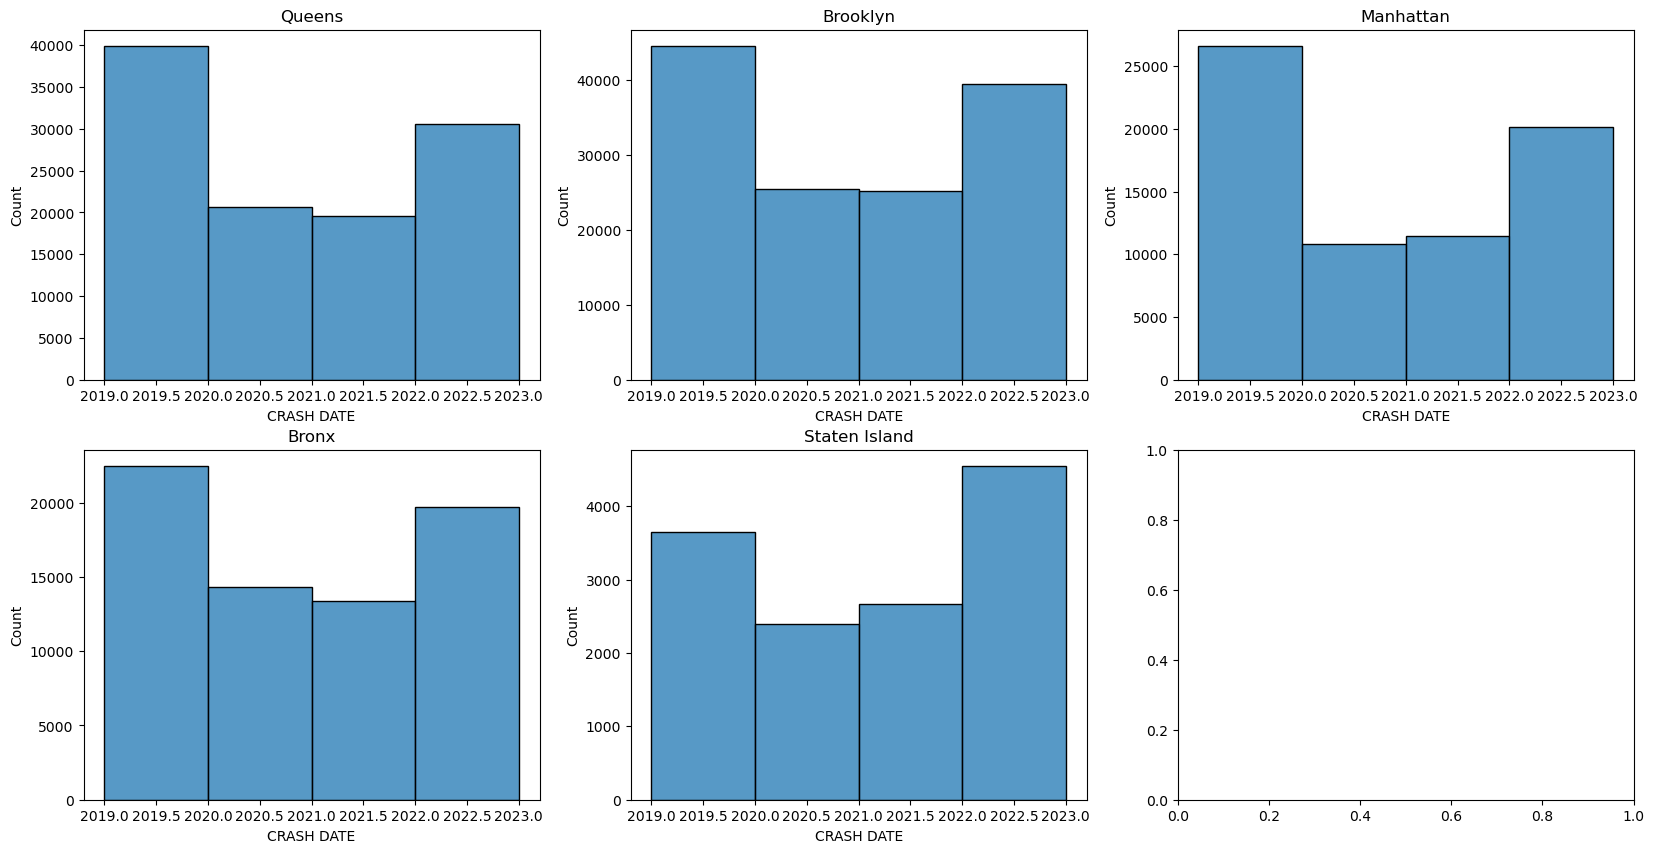

In [19]:
# Create space for SubPlots
fig, axs = plt.subplots(2, 3, figsize=(20, 10))

# Graph Crashes by Year for Queens
sns.histplot(
    MVC_Queens["CRASH DATE"].dt.year,
    bins=4,
    ax=axs[0][0],
).set(title="Queens")

# Graph Crashes by Year for Brooklyn
sns.histplot(
    MVC_Brooklyn["CRASH DATE"].dt.year,
    bins=4,
    ax=axs[0][1],
).set(title="Brooklyn")

# Graph Crashes by Year for Manhattan
sns.histplot(
    MVC_Manhattan["CRASH DATE"].dt.year,
    bins=4,
    ax=axs[0][2],
).set(title="Manhattan")

# Graph Crashes by Year for Bronx
sns.histplot(
    MVC_Bronx["CRASH DATE"].dt.year,
    bins=4,
    ax=axs[1][0],
).set(title="Bronx")
# Graph Crashes by Year for Staten Island
sns.histplot(
    MVC_StatenIsland["CRASH DATE"].dt.year,
    bins=4,
    ax=axs[1][1],
).set(title="Staten Island")

plt.show()

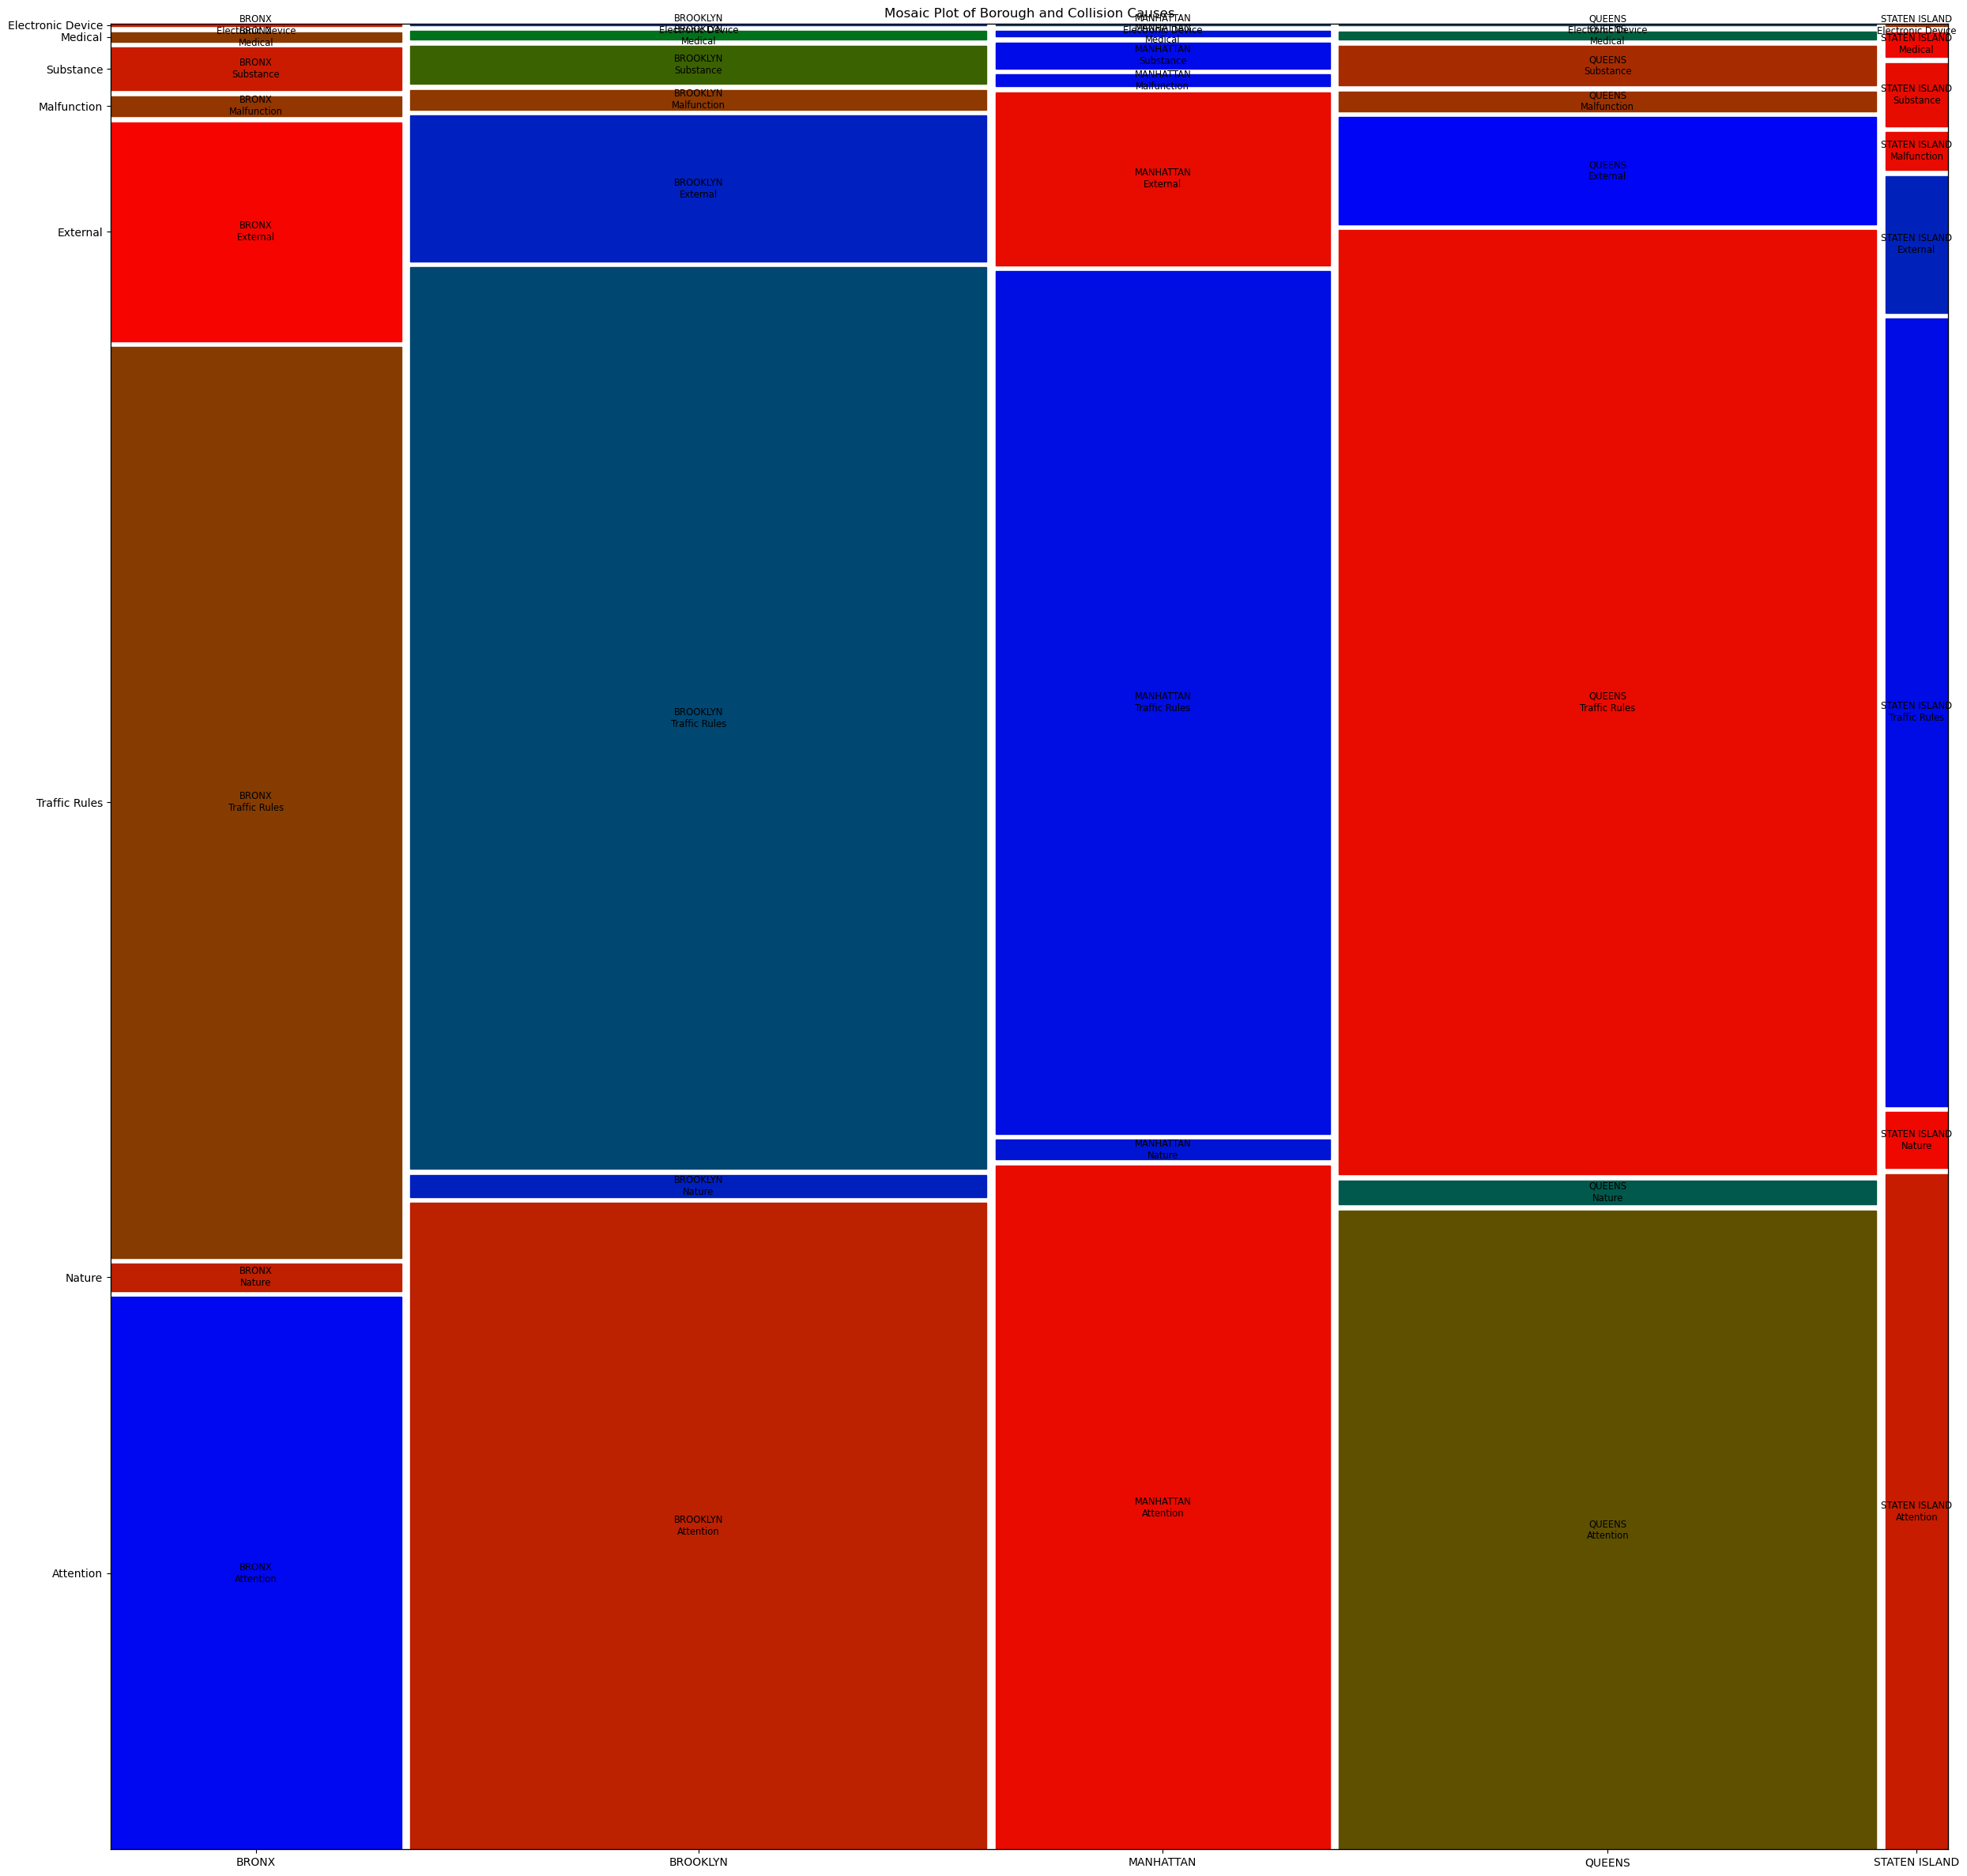

In [20]:
# Get Known Cause Categories
mvc_copy = mvc_cleaned_df[(mvc_cleaned_df["CAUSE CATEGORY 1"] != "Unknown") & (mvc_cleaned_df['BOROUGH'] != 'UNKNOWN')]

# Create Space for plot
fig, axs = plt.subplots(1, 1, figsize=(30, 30))

# Plot Mosaic of BOROUGH and Cause Category
mosaic(mvc_copy.sort_values("BOROUGH"), ["BOROUGH", "CAUSE CATEGORY 1"], statistic=True, ax=axs)
plt.title('Mosaic Plot of Borough and Collision Causes')
plt.show()

In [21]:
# Create Crosstab Table
table = pd.crosstab(mvc_copy["CAUSE CATEGORY 1"], mvc_copy["BOROUGH"], margins=False)
table = sm.stats.Table(table)

# Display Standardized Residuals and Value Counts 
display(table.standardized_resids)
display(mvc_copy.groupby("BOROUGH")["CAUSE CATEGORY 1"].value_counts())

# Perform and Output Chi-Squared Test 
X2 = table.test_nominal_association()
print(X2)

BOROUGH,BRONX,BROOKLYN,MANHATTAN,QUEENS,STATEN ISLAND
CAUSE CATEGORY 1,,,,,
Attention,-23.194364,4.025548,13.977996,0.834479,4.572684
Electronic Device,3.626347,-1.749477,-1.008761,-0.911530,1.588378
External,32.200734,-3.725978,11.607998,-30.776953,-2.945013
Malfunction,1.500424,1.508191,-10.420275,1.881405,10.556621
Medical,1.293210,-0.146308,-6.780016,-0.393926,13.139455
Nature,3.236512,-3.564651,-5.549581,-0.510274,15.617163
Substance,4.191770,0.363867,-11.781992,2.262796,10.003566
Traffic Rules,1.653317,-1.252125,-12.021154,15.509194,-13.342282


BOROUGH        CAUSE CATEGORY 1 
BRONX          Traffic Rules        23583
               Attention            14305
               External              5666
               Substance             1103
               Nature                 702
               Malfunction            524
               Medical                242
               Electronic Device       60
BROOKLYN       Traffic Rules        46259
               Attention            33166
               External              7477
               Substance             1963
               Nature                1142
               Malfunction           1017
               Medical                442
               Electronic Device       65
MANHATTAN      Traffic Rules        25693
               Attention            20366
               External              5162
               Substance              778
               Nature                 589
               Malfunction            345
               Medical                160
 

df          28
pvalue      0.0
statistic   3080.341687048518


### Data Analysis - Number of Vechicles Invovled

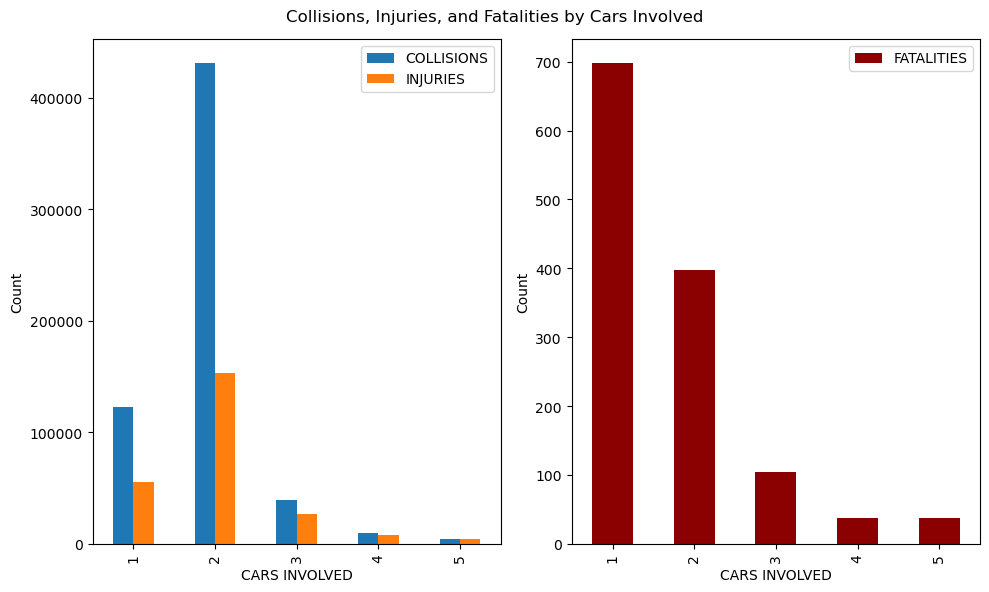

In [22]:
# Identify frequency of CARS INVOLVED
cars_inv_trends= mvc_cleaned_df.groupby('CARS INVOLVED').agg({'CARS INVOLVED': 'count', 'NUMBER OF PERSONS INJURED': 'sum', 'NUMBER OF PERSONS KILLED':'sum'})
cars_inv_trends.rename(columns={'CARS INVOLVED': 'COLLISIONS', 'NUMBER OF PERSONS INJURED': 'INJURIES', 'NUMBER OF PERSONS KILLED': 'FATALITIES'}, inplace=True)
cars_inv_trends.reset_index(drop = False, inplace=True)

# Define the Grid layout that will hold the graph plots
gs = gridspec.GridSpec(1,2)
fig = plt.figure(figsize=(10,6))

# Create sub-plots for the 2 graphs
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])

# Create Bar Graphs to show Count of Collisions and people Injured or Killed
cars_inv_trends.plot(x='CARS INVOLVED', y=['COLLISIONS', 'INJURIES'], ax=ax1, kind='bar')
cars_inv_trends.plot(x='CARS INVOLVED', y='FATALITIES', ax=ax2, kind='bar', color='darkred')

# Add Labels
ax1.set_ylabel('Count')
ax2.set_ylabel('Count')

# Pretty up the graphs
fig.tight_layout()
fig.supylabel('')
fig.supxlabel('')
fig.suptitle('Collisions, Injuries, and Fatalities by Cars Involved')
fig.subplots_adjust(top=.93)
plt.show()


### Data Analysis - Vehicle Contributing Factors

In [23]:
# Normalize Contributing Vehicle Factors across the five columns into a single column
id_vars = ['NUMBER OF PERSONS INJURED', 'NUMBER OF PERSONS KILLED', 'HAS INJURY', 'HAS FATALITY']
factors = ['CONTRIBUTING FACTOR VEHICLE 1', 'CONTRIBUTING FACTOR VEHICLE 2', 'CONTRIBUTING FACTOR VEHICLE 3', 'CONTRIBUTING FACTOR VEHICLE 4', 'CONTRIBUTING FACTOR VEHICLE 5']
factor_types = pd.melt(mvc_cleaned_df, id_vars=id_vars, value_vars=factors, var_name='FACTOR SOURCE', value_name='CONTRIBUTING FACTORS')

# Remove na or Unspecified rows
factor_types['CONTRIBUTING FACTORS'].fillna('Unspecified', inplace=True)
factor_types = factor_types[factor_types['CONTRIBUTING FACTORS'] != 'Unspecified']


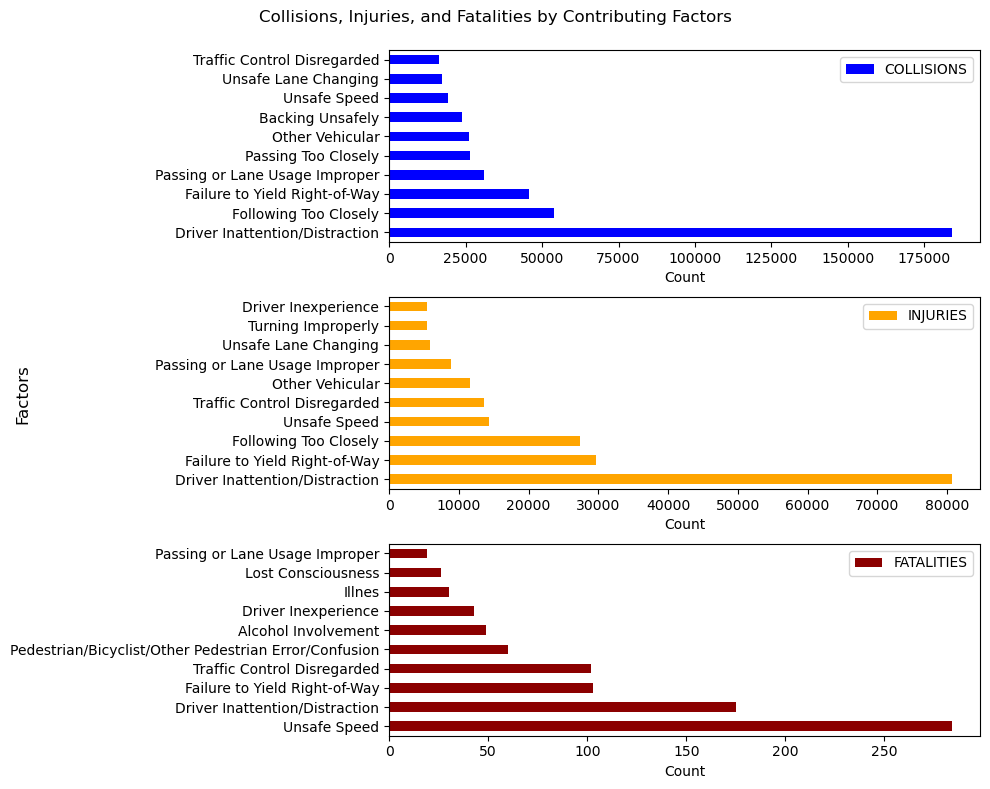

In [24]:
# Identify top 10 Contributing Factors
factor_trends= factor_types.groupby('CONTRIBUTING FACTORS').agg({'CONTRIBUTING FACTORS': 'count', 'NUMBER OF PERSONS INJURED': 'sum', 'NUMBER OF PERSONS KILLED':'sum'})
factor_trends.rename(columns={'CONTRIBUTING FACTORS': 'COLLISIONS', 'NUMBER OF PERSONS INJURED': 'INJURIES', 'NUMBER OF PERSONS KILLED': 'FATALITIES'}, inplace=True)
factor_trends.reset_index(drop = False, inplace=True)
factor_col = factor_trends.sort_values(factor_trends.columns[1], ascending = False)[:10]
factor_inj = factor_trends.sort_values(factor_trends.columns[2], ascending = False)[:10]
factor_fat = factor_trends.sort_values(factor_trends.columns[3], ascending = False)[:10]

# Define the Grid layout that will hold the graph plots
gs = gridspec.GridSpec(3,1)
fig = plt.figure(figsize=(10,8))

# Create sub-plots for the 2 graphs
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])
ax3 = fig.add_subplot(gs[2])

# Create Bar Graphs to show Count of Collisions and people Injured or Killed
factor_col.plot(x='CONTRIBUTING FACTORS', y='COLLISIONS', ax=ax1, kind='barh', color='blue')
factor_inj.plot(x='CONTRIBUTING FACTORS', y='INJURIES', ax=ax2, kind='barh', color='orange')
factor_fat.plot(x='CONTRIBUTING FACTORS', y='FATALITIES', ax=ax3, kind='barh', color='darkred')

# Add Labels
ax1.set_xlabel('Count')
ax2.set_xlabel('Count')
ax3.set_xlabel('Count')
ax1.set_ylabel('')
ax2.set_ylabel('')
ax3.set_ylabel('')

# Pretty up the graphs
fig.tight_layout()
fig.supylabel('Factors')
fig.supxlabel('')
fig.suptitle('Collisions, Injuries, and Fatalities by Contributing Factors')
fig.subplots_adjust(top=.93)
plt.show()

In [25]:
# Normalize Contributing Vehicle Factor Categories across the five columns into a single column
id_vars = ['NUMBER OF PERSONS INJURED', 'NUMBER OF PERSONS KILLED', 'HAS INJURY', 'HAS FATALITY']
factors = ['CAUSE CATEGORY 1', 'CAUSE CATEGORY 2', 'CAUSE CATEGORY 3', 'CAUSE CATEGORY 4', 'CAUSE CATEGORY 5']
factor_cats = pd.melt(mvc_cleaned_df, id_vars=id_vars, value_vars=factors, var_name='CATEGORY SOURCE', value_name='FACTOR CATEGORY')

# Remove Unknown category
factor_cats = factor_cats[factor_cats['FACTOR CATEGORY'] != 'Unknown']


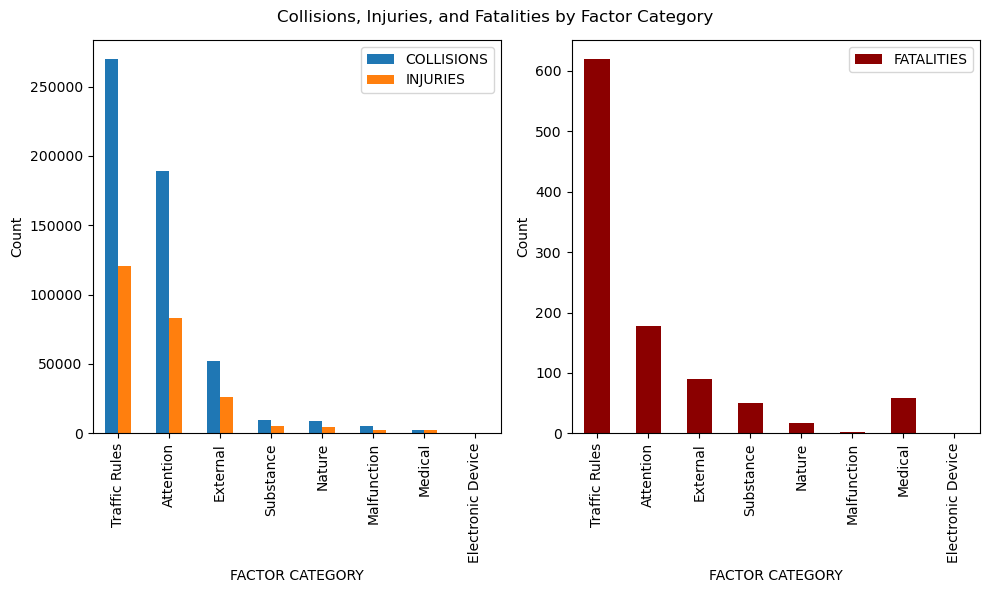

In [26]:
# Identify trends by Contributing Category
cat_trends= factor_cats.groupby('FACTOR CATEGORY').agg({'FACTOR CATEGORY': 'count', 'NUMBER OF PERSONS INJURED': 'sum', 'NUMBER OF PERSONS KILLED':'sum'})
cat_trends.rename(columns={'FACTOR CATEGORY': 'COLLISIONS', 'NUMBER OF PERSONS INJURED': 'INJURIES', 'NUMBER OF PERSONS KILLED': 'FATALITIES'}, inplace=True)
cat_trends.reset_index(drop = False, inplace=True)
cat_trends.sort_values(factor_trends.columns[1], ascending = False, inplace=True)

# Define the Grid layout that will hold the graph plots
gs = gridspec.GridSpec(1,2)
fig = plt.figure(figsize=(10,6))

# Create sub-plots for the 2 graphs
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])

# Create Bar Graphs to show Count of Collisions and people Injured or Killed
cat_trends.plot(x='FACTOR CATEGORY', y=['COLLISIONS', 'INJURIES'], ax=ax1, kind='bar')
cat_trends.plot(x='FACTOR CATEGORY', y='FATALITIES', ax=ax2, kind='bar', color='darkred')

# Add Labels
ax1.set_ylabel('Count')
ax2.set_ylabel('Count')

# Pretty up the graphs
fig.tight_layout()
fig.supylabel('')
fig.supxlabel('')
fig.suptitle('Collisions, Injuries, and Fatalities by Factor Category')
fig.subplots_adjust(top=.93)
plt.show()


In [27]:
# Create Cross-Tab table for Injuries by Contributing Factor (Counts)
injury_crosstab_df = pd.crosstab(factor_cats['FACTOR CATEGORY'], factor_cats['HAS INJURY'], margins=True, margins_name="Total")

# Sort by number of collissions
injury_crosstab_df.sort_values(injury_crosstab_df.columns[2], ascending = False, inplace=True)

# Output Count Crosstab
display(injury_crosstab_df)

# Create Cross-Tab table for Injuries by Contributing Factor (Injury Percentages)
p_injury_crosstab_df = pd.crosstab(factor_cats['FACTOR CATEGORY'], factor_cats['HAS INJURY'], normalize='index')

# Sort by collission Injury Rate
p_injury_crosstab_df.sort_values(p_injury_crosstab_df.columns[1], ascending = False, inplace=True)

# Output Percentagess Crosstab
display(p_injury_crosstab_df)

# Filter out Total
injury_crosstab_df = injury_crosstab_df[injury_crosstab_df.index !='Total']
# Perform Chi-Squared test, and calculate p-value
chi2_stat, p_value, dof, expected = chi2_contingency(injury_crosstab_df, correction=False)
print("The p-value is: %.5f" % p_value)
print("The chi-squared statistic is: %.2f" % chi2_stat)
print('')

# Create a Table object from the crosstab table
accident_table = sm.stats.Table(injury_crosstab_df)

# Output the Standardized Residuals
print('The standardized residuals are:\n')
display(accident_table.standardized_resids)
print('')

HAS INJURY,0,1,Total
FACTOR CATEGORY,,,
Total,360881,176613,537494
Traffic Rules,184458,85595,270053
Attention,127069,61889,188958
External,32995,19005,52000
Substance,6076,3293,9369
Nature,5903,3219,9122
Malfunction,3478,1845,5323
Medical,626,1567,2193
Electronic Device,276,200,476


HAS INJURY,0,1
FACTOR CATEGORY,,
Medical,0.285454,0.714546
Electronic Device,0.579832,0.420168
External,0.634519,0.365481
Nature,0.647117,0.352883
Substance,0.648522,0.351478
Malfunction,0.653391,0.346609
Attention,0.672472,0.327528
Traffic Rules,0.683044,0.316956


The p-value is: 0.00000
The chi-squared statistic is: 2040.72

The standardized residuals are:



HAS INJURY,0,1,Total
FACTOR CATEGORY,,,
Traffic Rules,12.828932,-16.349859,2.245657e-13
Attention,0.855325,-1.090071,0.000000e+00
External,-13.255203,16.893120,0.000000e+00
Substance,-3.347181,4.265822,0.000000e+00
Nature,-3.504630,4.466483,0.000000e+00
Malfunction,-1.978759,2.521834,0.000000e+00
Medical,-27.119063,34.561945,0.000000e+00
Electronic Device,-2.993169,3.814651,0.000000e+00


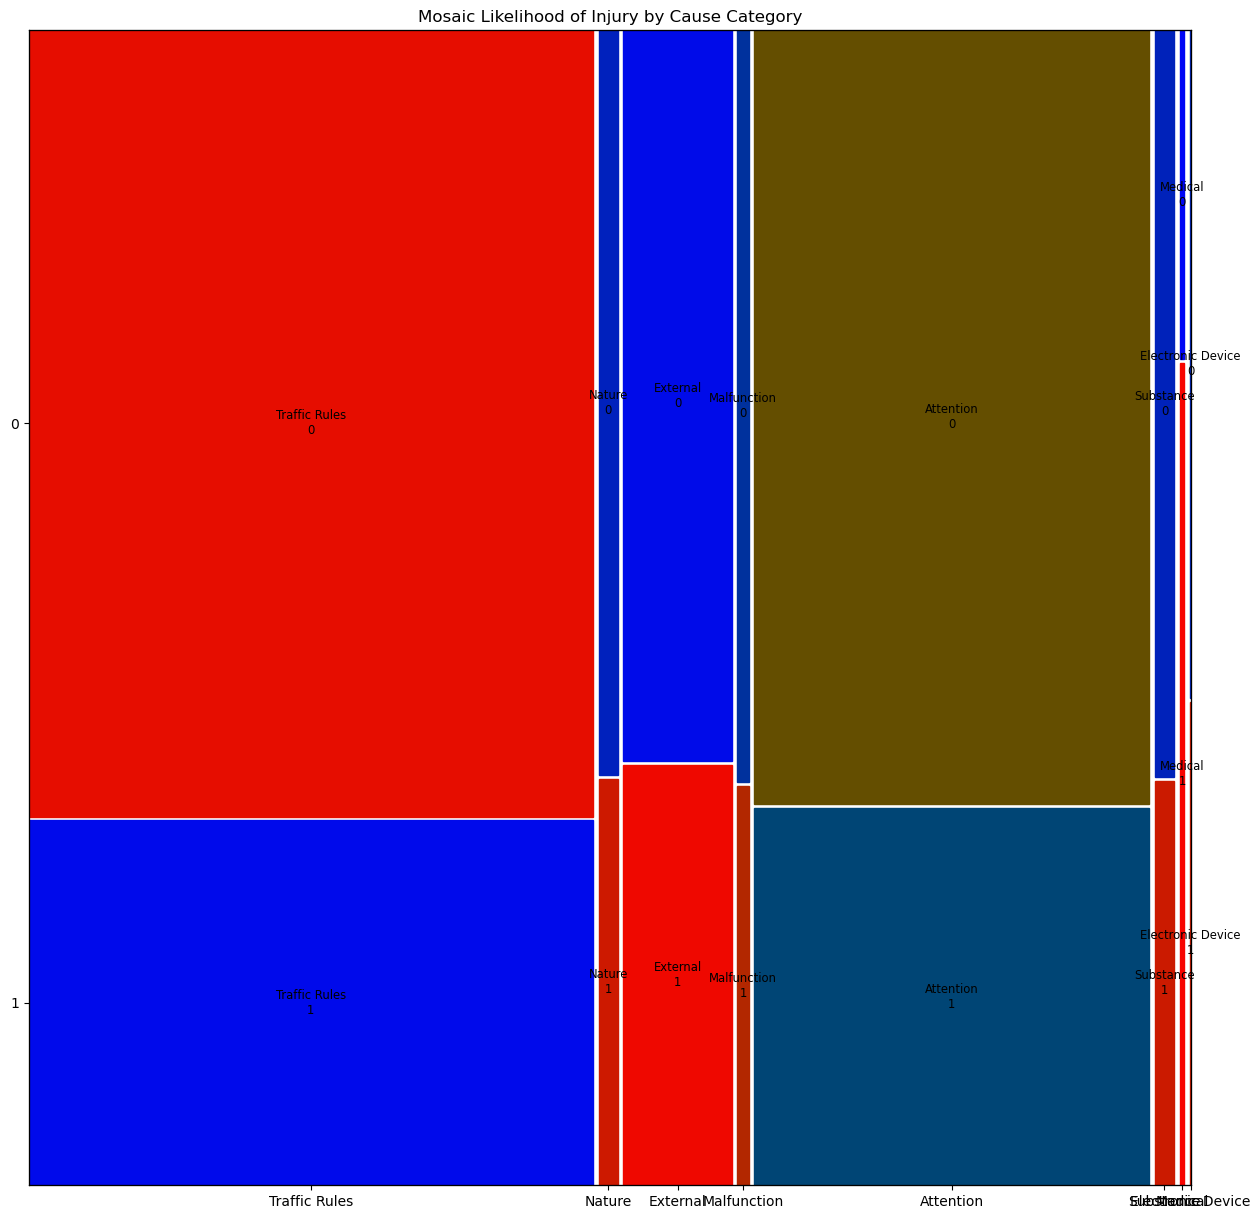

In [28]:
# Generate and Output the Mosaic Plot
fig, ax = plt.subplots(figsize=(15,15))
mosaic(factor_cats, ['FACTOR CATEGORY','HAS INJURY'], statistic=True, title='Mosaic Likelihood of Injury by Cause Category', ax=ax)
plt.show()

In [29]:
# Create Cross-Tab table for Injuries by Contributing Factor (Counts)
injury_crosstab_df = pd.crosstab(factor_cats['FACTOR CATEGORY'], factor_cats['HAS FATALITY'], margins=True, margins_name="Total")

# Sort by number of collissions
injury_crosstab_df.sort_values(injury_crosstab_df.columns[2], ascending = False, inplace=True)

# Output Count Crosstab
display(injury_crosstab_df)

# Create Cross-Tab table for Injuries by Contributing Factor (Injury Percentages)
p_injury_crosstab_df = pd.crosstab(factor_cats['FACTOR CATEGORY'], factor_cats['HAS FATALITY'], normalize='index')

# Sort by collission Injury Rate
p_injury_crosstab_df.sort_values(p_injury_crosstab_df.columns[1], ascending = False, inplace=True)

# Output Percentagess Crosstab
display(p_injury_crosstab_df)

# Filter out Total
injury_crosstab_df = injury_crosstab_df[injury_crosstab_df.index !='Total']
# Perform Chi-Squared test, and calculate p-value
chi2_stat, p_value, dof, expected = chi2_contingency(injury_crosstab_df, correction=False)
print("The p-value is: %.5f" % p_value)
print("The chi-squared statistic is: %.2f" % chi2_stat)
print('')

# Create a Table object from the crosstab table
accident_table = sm.stats.Table(injury_crosstab_df)

# Output the Standardized Residuals
print('The standardized residuals are:\n')
display(accident_table.standardized_resids)
print('')

HAS FATALITY,0,1,Total
FACTOR CATEGORY,,,
Total,536534,960,537494
Traffic Rules,269482,571,270053
Attention,188784,174,188958
External,51911,89,52000
Substance,9318,51,9369
Nature,9105,17,9122
Malfunction,5321,2,5323
Medical,2137,56,2193
Electronic Device,476,0,476


HAS FATALITY,0,1
FACTOR CATEGORY,,
Medical,0.974464,0.025536
Substance,0.994557,0.005443
Traffic Rules,0.997886,0.002114
Nature,0.998136,0.001864
External,0.998288,0.001712
Attention,0.999079,0.000921
Malfunction,0.999624,0.000376
Electronic Device,1.000000,0.000000


The p-value is: 0.00000
The chi-squared statistic is: 866.75

The standardized residuals are:



HAS FATALITY,0,1,Total
FACTOR CATEGORY,,,
Traffic Rules,-0.341596,5.708387,0.000485
Attention,0.660883,-11.065580,0.000355
External,0.025447,-0.428480,0.000158
Substance,-0.505010,8.450094,0.000064
Nature,-0.010503,0.174701,0.000063
Malfunction,0.146292,-2.448957,0.000048
Medical,-1.576061,26.374310,0.000031
Electronic Device,0.038953,-0.380877,-0.016194


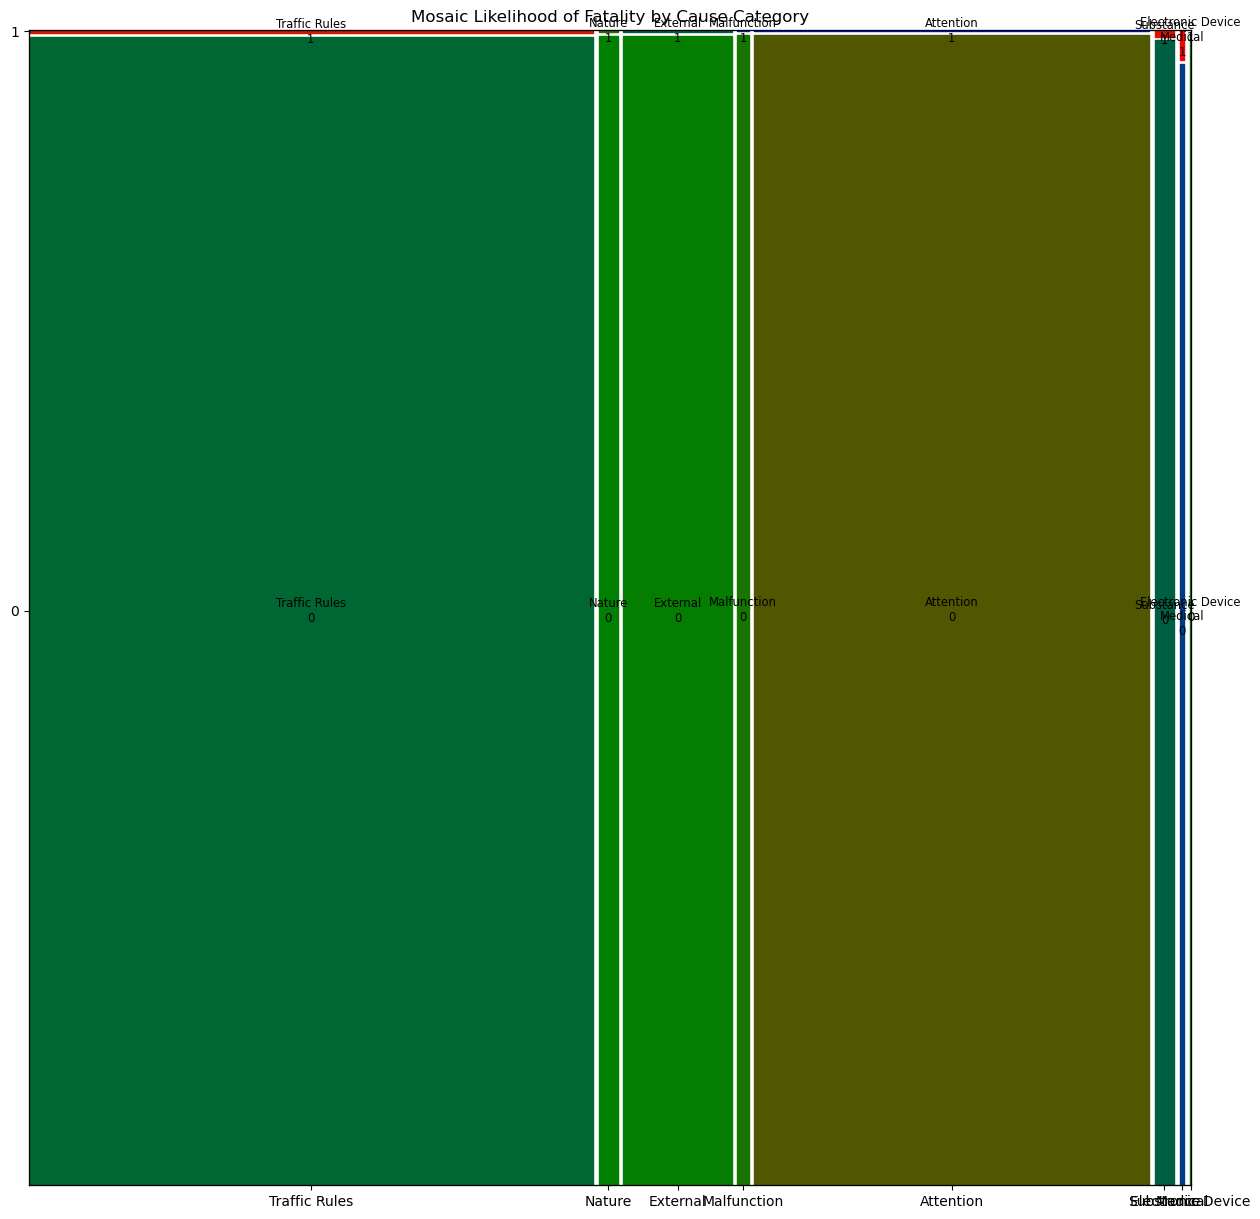

In [30]:
# Generate and Output the Mosaic Plot
fig, ax = plt.subplots(figsize=(15,15))
mosaic(factor_cats, ['FACTOR CATEGORY','HAS FATALITY'], statistic=True, title='Mosaic Likelihood of Fatality by Cause Category', ax=ax)
plt.show()

### Data Analysis - Vehicle Types

In [31]:
# Normalize Vehicle Types across the five type codes into a single column
id_vars = ['NUMBER OF PERSONS INJURED', 'NUMBER OF PERSONS KILLED', 'HAS INJURY', 'HAS FATALITY']
value_vars = ['VEHICLE TYPE CODE 1', 'VEHICLE TYPE CODE 2', 'VEHICLE TYPE CODE 3', 'VEHICLE TYPE CODE 4', 'VEHICLE TYPE CODE 5']
vehicle_types = pd.melt(mvc_cleaned_df, id_vars=id_vars, value_vars=value_vars, var_name='VEHICLE TYPES SOURCE', value_name='VEHICLE TYPES')
vehicle_types.dropna(inplace=True)

# Remove Unknown category
vehicle_types = vehicle_types[vehicle_types['VEHICLE TYPES'] != 'Unknown']
vehicle_types.head()


,NUMBER OF PERSONS INJURED,NUMBER OF PERSONS KILLED,HAS INJURY,HAS FATALITY,VEHICLE TYPES SOURCE,VEHICLE TYPES
0,2.0,0.0,1,0,VEHICLE TYPE CODE 1,Sedan
1,1.0,0.0,1,0,VEHICLE TYPE CODE 1,Sedan
2,0.0,0.0,0,0,VEHICLE TYPE CODE 1,Sedan
3,0.0,0.0,0,0,VEHICLE TYPE CODE 1,Sedan
5,0.0,0.0,0,0,VEHICLE TYPE CODE 1,Dump


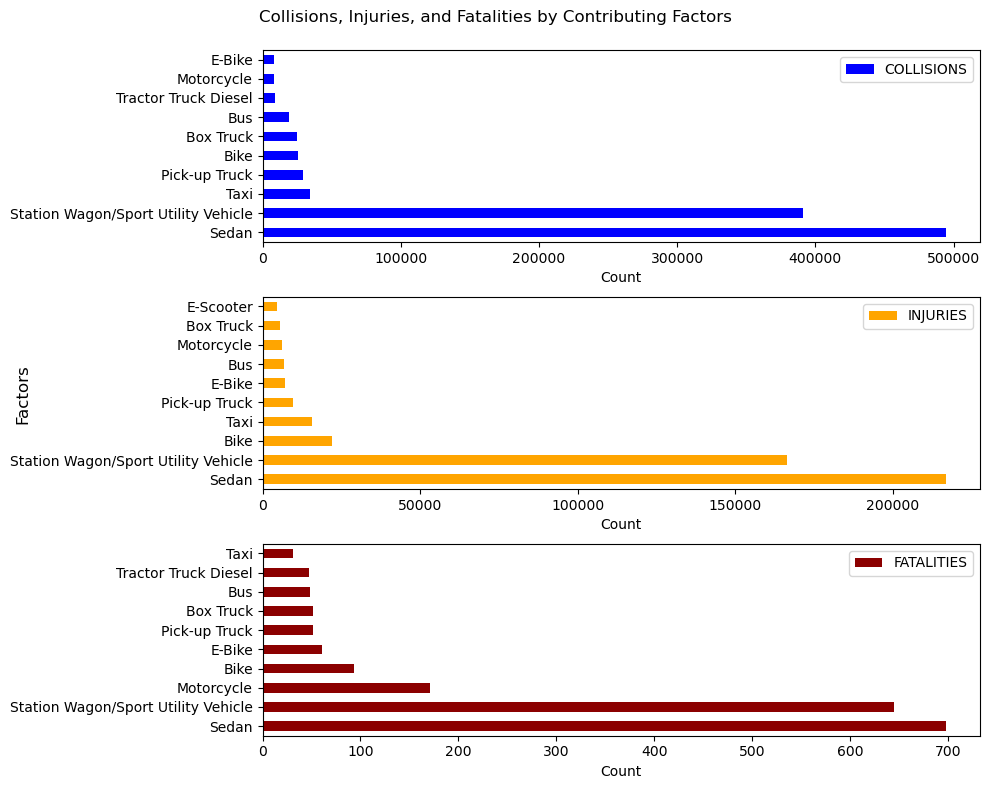

In [32]:
# Identify top 10 Vehicle Types
vehicle_types= vehicle_types.groupby('VEHICLE TYPES').agg({'VEHICLE TYPES': 'count', 'NUMBER OF PERSONS INJURED': 'sum', 'NUMBER OF PERSONS KILLED':'sum'})
vehicle_types.rename(columns={'VEHICLE TYPES': 'COLLISIONS', 'NUMBER OF PERSONS INJURED': 'INJURIES', 'NUMBER OF PERSONS KILLED': 'FATALITIES'}, inplace=True)
vehicle_types.reset_index(drop = False, inplace=True)
vehicle_types_col = vehicle_types.sort_values(factor_trends.columns[1], ascending = False)[:10]
vehicle_types_inj = vehicle_types.sort_values(factor_trends.columns[2], ascending = False)[:10]
vehicle_types_fat = vehicle_types.sort_values(factor_trends.columns[3], ascending = False)[:10]

# Define the Grid layout that will hold the graph plots
gs = gridspec.GridSpec(3,1)
fig = plt.figure(figsize=(10,8))

# Create sub-plots for the 2 graphs
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])
ax3 = fig.add_subplot(gs[2])

# Create Bar Graphs to show Count of Collisions and people Injured or Killed
vehicle_types_col.plot(x='VEHICLE TYPES', y='COLLISIONS', ax=ax1, kind='barh', color='blue')
vehicle_types_inj.plot(x='VEHICLE TYPES', y='INJURIES', ax=ax2, kind='barh', color='orange')
vehicle_types_fat.plot(x='VEHICLE TYPES', y='FATALITIES', ax=ax3, kind='barh', color='darkred')

# Add Labels
ax1.set_xlabel('Count')
ax2.set_xlabel('Count')
ax3.set_xlabel('Count')
ax1.set_ylabel('')
ax2.set_ylabel('')
ax3.set_ylabel('')

# Pretty up the graphs
fig.tight_layout()
fig.supylabel('Factors')
fig.supxlabel('')
fig.suptitle('Collisions, Injuries, and Fatalities by Contributing Factors')
fig.subplots_adjust(top=.93)
plt.show()

In [33]:
# Normalize Vehicle Type Categories across the five type codes into a single column
id_vars = ['NUMBER OF PERSONS INJURED', 'NUMBER OF PERSONS KILLED', 'HAS INJURY', 'HAS FATALITY']
cat_vars = ['VEHICLE CATEGORY 1', 'VEHICLE CATEGORY 2', 'VEHICLE CATEGORY 3', 'VEHICLE CATEGORY 3', 'VEHICLE CATEGORY 5']
vehicle_cats = pd.melt(mvc_cleaned_df, id_vars=id_vars, value_vars=cat_vars, var_name='VEHICLE CAT SOURCE', value_name='VEHICLE CATEGORY')
vehicle_cats.dropna(inplace=True)

# Remove Unknown category
vehicle_cats = vehicle_cats[vehicle_cats['VEHICLE CATEGORY'] != 'Unknown']
vehicle_cats.head()


,NUMBER OF PERSONS INJURED,NUMBER OF PERSONS KILLED,HAS INJURY,HAS FATALITY,VEHICLE CAT SOURCE,VEHICLE CATEGORY
0,2.0,0.0,1,0,VEHICLE CATEGORY 1,Car
1,1.0,0.0,1,0,VEHICLE CATEGORY 1,Car
2,0.0,0.0,0,0,VEHICLE CATEGORY 1,Car
3,0.0,0.0,0,0,VEHICLE CATEGORY 1,Car
5,0.0,0.0,0,0,VEHICLE CATEGORY 1,Service Vehicle


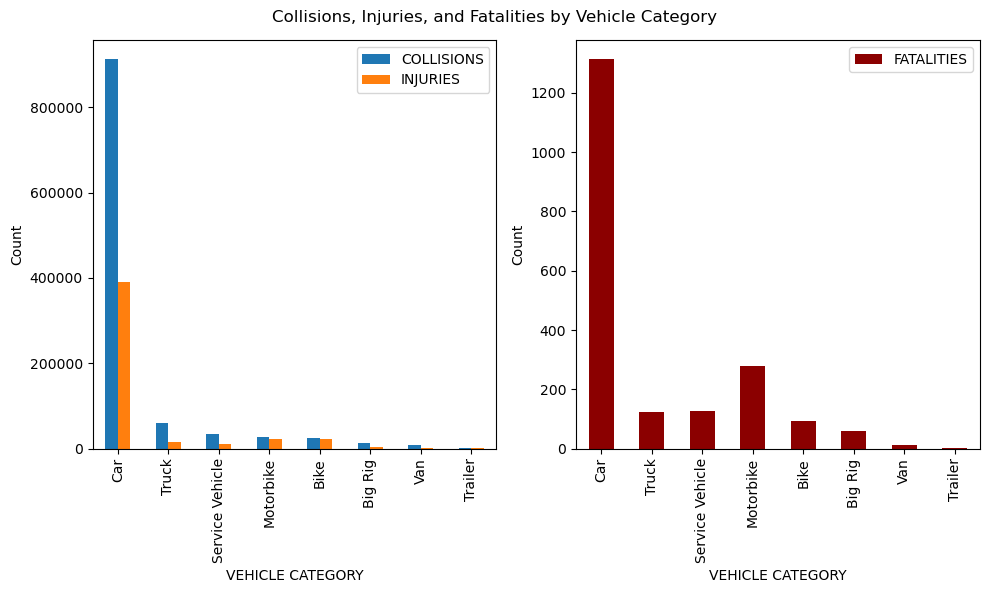

In [34]:
# Identify trends by Vehicle Category
cat_trends= vehicle_cats.groupby('VEHICLE CATEGORY').agg({'VEHICLE CATEGORY': 'count', 'NUMBER OF PERSONS INJURED': 'sum', 'NUMBER OF PERSONS KILLED':'sum'})
cat_trends.rename(columns={'VEHICLE CATEGORY': 'COLLISIONS', 'NUMBER OF PERSONS INJURED': 'INJURIES', 'NUMBER OF PERSONS KILLED': 'FATALITIES'}, inplace=True)
cat_trends.reset_index(drop = False, inplace=True)
cat_trends.sort_values(factor_trends.columns[1], ascending = False, inplace=True)

# Define the Grid layout that will hold the graph plots
gs = gridspec.GridSpec(1,2)
fig = plt.figure(figsize=(10,6))

# Create sub-plots for the 2 graphs
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])

# Create Bar Graphs to show Count of Collisions and people Injured or Killed
cat_trends.plot(x='VEHICLE CATEGORY', y=['COLLISIONS', 'INJURIES'], ax=ax1, kind='bar')
cat_trends.plot(x='VEHICLE CATEGORY', y='FATALITIES', ax=ax2, kind='bar', color='darkred')

# Add Labels
ax1.set_ylabel('Count')
ax2.set_ylabel('Count')

# Pretty up the graphs
fig.tight_layout()
fig.supylabel('')
fig.supxlabel('')
fig.suptitle('Collisions, Injuries, and Fatalities by Vehicle Category')
fig.subplots_adjust(top=.93)
plt.show()

### Modeling - Has Injury / Fatality (Binomial)

In [35]:
modeling_df = mvc_cleaned_df.drop(['YEAR', 'CRASH DATE','CRASH TIME','NUMBER OF PERSONS INJURED', 'NUMBER OF PERSONS KILLED',
              'NUMBER OF PEDESTRIANS INJURED','NUMBER OF PEDESTRIANS KILLED', 'NUMBER OF CYCLIST INJURED','NUMBER OF CYCLIST KILLED', 
              'NUMBER OF MOTORIST INJURED','NUMBER OF MOTORIST KILLED','CONTRIBUTING FACTOR VEHICLE 1',
              'CONTRIBUTING FACTOR VEHICLE 2', 'CONTRIBUTING FACTOR VEHICLE 3',
              'CONTRIBUTING FACTOR VEHICLE 4','CONTRIBUTING FACTOR VEHICLE 5', 'VEHICLE TYPE CODE 1', 
              'VEHICLE TYPE CODE 2', 'VEHICLE TYPE CODE 3', 'VEHICLE TYPE CODE 4', 'VEHICLE TYPE CODE 5'], axis=1)
modeling_df = modeling_df[modeling_df['CAUSE CATEGORY 1'] != 'Unknown']
modeling_df = modeling_df[modeling_df['VEHICLE CATEGORY 1'] != 'Unknown']
modeling_df.head()

,BOROUGH,CRASH HOUR,DAY OF WEEK,CRASH MONTH,CRASH HOUR CONT,CARS INVOLVED,HAS INJURY,HAS FATALITY,INJURY AND FATALITY,CAUSE CATEGORY 1,CAUSE CATEGORY 2,CAUSE CATEGORY 3,CAUSE CATEGORY 4,CAUSE CATEGORY 5,VEHICLE CATEGORY 1,VEHICLE CATEGORY 2,VEHICLE CATEGORY 3,VEHICLE CATEGORY 4,VEHICLE CATEGORY 5
0,UNKNOWN,2,5,9,2.650000,2,1,0,2.0,Traffic Rules,Unknown,Unknown,Unknown,Unknown,Car,Car,Unknown,Unknown,Unknown
1,UNKNOWN,11,5,3,11.750000,1,1,0,1.0,Nature,Unknown,Unknown,Unknown,Unknown,Car,Unknown,Unknown,Unknown,Unknown
2,UNKNOWN,6,2,6,6.916667,2,0,0,0.0,Traffic Rules,Unknown,Unknown,Unknown,Unknown,Car,Truck,Unknown,Unknown,Unknown
6,UNKNOWN,17,1,12,17.083333,2,0,0,0.0,Traffic Rules,Unknown,Unknown,Unknown,Unknown,Car,Big Rig,Unknown,Unknown,Unknown
8,BROOKLYN,21,1,12,21.166667,2,0,0,0.0,Traffic Rules,Unknown,Unknown,Unknown,Unknown,Car,Unknown,Unknown,Unknown,Unknown


In [36]:
binomial_data_injury = modeling_df.copy()
binomial_data_injury = pd.get_dummies(binomial_data_injury, columns = ['BOROUGH', 'CAUSE CATEGORY 1', 'CAUSE CATEGORY 2', 'CAUSE CATEGORY 3',
                                                           'CAUSE CATEGORY 4', 'CAUSE CATEGORY 5',  'VEHICLE CATEGORY 1',
                                                          'VEHICLE CATEGORY 2','VEHICLE CATEGORY 3','VEHICLE CATEGORY 4','VEHICLE CATEGORY 5'])

display(binomial_data_injury.corr(numeric_only=True))

,CRASH HOUR,DAY OF WEEK,CRASH MONTH,CRASH HOUR CONT,CARS INVOLVED,HAS INJURY,HAS FATALITY,INJURY AND FATALITY,BOROUGH_BRONX,BOROUGH_BROOKLYN,...,VEHICLE CATEGORY 4_Van,VEHICLE CATEGORY 5_Big Rig,VEHICLE CATEGORY 5_Bike,VEHICLE CATEGORY 5_Car,VEHICLE CATEGORY 5_Motorbike,VEHICLE CATEGORY 5_Service Vehicle,VEHICLE CATEGORY 5_Trailer,VEHICLE CATEGORY 5_Truck,VEHICLE CATEGORY 5_Unknown,VEHICLE CATEGORY 5_Van
CRASH HOUR,1.000000,-0.020799,0.004531,0.998774,-0.015525,0.041396,-0.009142,0.031585,-0.002286,0.012111,...,-0.002882,-0.001504,0.002897,-0.021554,0.002693,-0.000416,-0.002440,-0.004524,0.021778,-0.003087
DAY OF WEEK,-0.020799,1.000000,-0.000670,-0.020607,0.025718,0.005860,0.004933,0.019337,-0.001122,-0.006255,...,-0.002465,-0.000657,-0.000603,0.016954,0.000028,-0.001384,-0.001488,-0.000155,-0.016199,-0.000595
CRASH MONTH,0.004531,-0.000670,1.000000,0.004534,0.000649,0.040628,0.005075,0.030819,0.000588,0.000343,...,0.001449,-0.001274,0.003065,0.001950,0.001760,-0.000008,-0.001896,0.000018,-0.001980,-0.001287
CRASH HOUR CONT,0.998774,-0.020607,0.004534,1.000000,-0.015525,0.043390,-0.008708,0.033267,-0.001678,0.012142,...,-0.002775,-0.001502,0.002922,-0.021218,0.002742,-0.000359,-0.002381,-0.004481,0.021429,-0.003041
CARS INVOLVED,-0.015525,0.025718,0.000649,-0.015525,1.000000,-0.064588,-0.017474,0.049142,-0.008537,0.011718,...,0.035508,0.023271,0.017345,0.434768,0.039043,0.037470,0.007757,0.080249,-0.447749,0.031984
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
VEHICLE CATEGORY 5_Service Vehicle,-0.000416,-0.001384,-0.000008,-0.000359,0.037470,0.004808,-0.000320,0.016994,0.003616,0.002425,...,-0.000068,-0.000033,-0.000024,-0.000611,-0.000055,1.000000,-0.000011,-0.000112,-0.084609,-0.000045
VEHICLE CATEGORY 5_Trailer,-0.002440,-0.001488,-0.001896,-0.002381,0.007757,-0.001018,-0.000065,-0.000816,-0.000499,-0.000746,...,-0.000014,-0.000007,-0.000005,-0.000125,-0.000011,-0.000011,1.000000,-0.000023,-0.017270,-0.000009
VEHICLE CATEGORY 5_Truck,-0.004524,-0.000155,0.000018,-0.004481,0.080249,0.006480,-0.000677,0.011627,0.000102,0.000562,...,0.015339,-0.000069,-0.000051,-0.001291,-0.000117,-0.000112,-0.000023,1.000000,-0.178666,-0.000095
VEHICLE CATEGORY 5_Unknown,0.021778,-0.016199,-0.001980,0.021429,-0.447749,-0.033282,-0.013956,-0.070071,-0.004088,-0.012834,...,-0.021487,-0.051811,-0.038618,-0.970984,-0.088064,-0.084609,-0.017270,-0.178666,1.000000,-0.071208


In [37]:
# Create X - assign independent variables, dependent variable, respectively
x = binomial_data_injury.loc[:, binomial_data_injury.columns != 'HAS INJURY']

# Create Y - define the target
y = pd.DataFrame(binomial_data_injury['HAS INJURY'])

# Split Data into Test and Train
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

#x_train = sm.add_constant(x_train)
glm_binom_model = sm.GLM(y_train, x_train, family=sm.families.Binomial(link=sm.families.links.logit())).fit()
display(glm_binom_model.summary())

#use model to predict probability that given y value is 1
y_predict = glm_binom_model.predict(x_test)

#calculate AUC of model
auc = roc_auc_score(y_test, y_predict)

#print AUC score
print('(AUC) GLM Logistic Regression: %.4f' % auc)



ValueError: Pandas data cast to numpy dtype of object. Check input data with np.asarray(data).

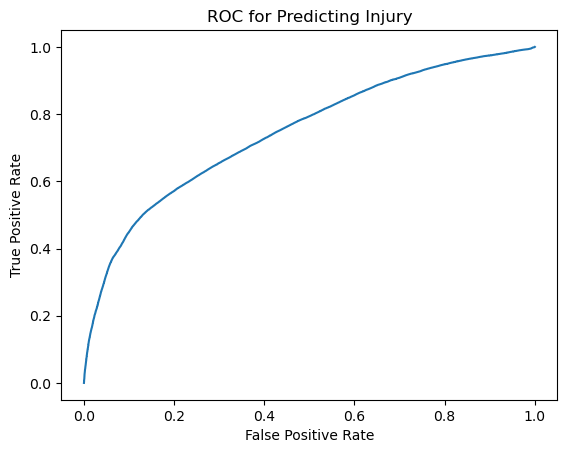

In [ ]:
#define metrics
fpr, tpr, _ = metrics.roc_curve(y_test,  y_predict)

#create ROC curve
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC for Predicting Injury')
plt.show()

AttributeError: 'PandasData' object has no attribute 'design_info'

In [ ]:
binomial_data_fatality = modeling_df.copy()
binomial_data_fatality.drop(['HAS INJURY', 'CAUSE CATEGORY 4','CAUSE CATEGORY 5','VEHICLE CATEGORY 1', 'VEHICLE CATEGORY 2','VEHICLE CATEGORY 3', 'VEHICLE CATEGORY 4', 'VEHICLE CATEGORY 5'], axis=1, inplace=True)
binomial_data_fatality = pd.get_dummies(binomial_data_fatality, columns = ['BOROUGH', 'CAUSE CATEGORY 1', 'CAUSE CATEGORY 2', 'CAUSE CATEGORY 3'])

display(binomial_data_fatality.corr(numeric_only=True))

,CRASH HOUR,DAY OF WEEK,CRASH MONTH,CARS INVOLVED,HAS FATALITY,BOROUGH_BRONX,BOROUGH_BROOKLYN,BOROUGH_MANHATTAN,BOROUGH_QUEENS,BOROUGH_STATEN ISLAND,...,CAUSE CATEGORY 2_Unknown,CAUSE CATEGORY 3_Attention,CAUSE CATEGORY 3_Electronic Device,CAUSE CATEGORY 3_External,CAUSE CATEGORY 3_Malfunction,CAUSE CATEGORY 3_Medical,CAUSE CATEGORY 3_Nature,CAUSE CATEGORY 3_Substance,CAUSE CATEGORY 3_Traffic Rules,CAUSE CATEGORY 3_Unknown
CRASH HOUR,1.000000,-0.020799,0.004531,-0.015525,-0.009142,-0.002286,0.012111,0.009004,0.005318,0.009104,...,-0.021009,0.000088,0.001241,-0.011140,0.002926,-0.002235,-0.008597,-0.000398,0.002276,0.006906
DAY OF WEEK,-0.020799,1.000000,-0.000670,0.025718,0.004933,-0.001122,-0.006255,-0.001290,0.006119,-0.000470,...,0.006260,0.001582,0.002202,0.007463,0.002026,0.002741,0.002529,0.004360,0.001915,-0.007553
CRASH MONTH,0.004531,-0.000670,1.000000,0.000649,0.005075,0.000588,0.000343,0.000063,0.000427,-0.005782,...,0.002142,-0.000340,0.001065,0.001811,-0.002552,-0.001745,-0.007231,-0.002729,-0.000928,0.001667
CARS INVOLVED,-0.015525,0.025718,0.000649,1.000000,-0.017474,-0.008537,0.011718,-0.053400,0.009477,-0.015246,...,-0.121331,0.094067,0.003599,0.128836,0.009899,0.003599,0.054215,0.021553,0.143718,-0.222889
HAS FATALITY,-0.009142,0.004933,0.005075,-0.017474,1.000000,-0.002592,-0.000217,-0.003418,-0.006397,0.001426,...,0.010432,-0.000429,-0.000093,-0.000186,-0.000236,-0.000093,0.001951,-0.000358,-0.002289,0.001346
BOROUGH_BRONX,-0.002286,-0.001122,0.000588,-0.008537,-0.002592,1.000000,-0.167611,-0.121324,-0.160673,-0.049970,...,-0.013220,-0.005038,-0.000705,0.008172,-0.001799,-0.000705,-0.003743,-0.001829,-0.009089,0.004214
BOROUGH_BROOKLYN,0.012111,-0.006255,0.000343,0.011718,-0.000217,-0.167611,1.000000,-0.181370,-0.240194,-0.074702,...,0.030458,-0.012836,0.001577,-0.002147,0.002473,-0.001055,-0.006780,0.003390,-0.018094,0.019310
BOROUGH_MANHATTAN,0.009004,-0.001290,0.000063,-0.053400,-0.003418,-0.121324,-0.181370,1.000000,-0.173863,-0.054072,...,-0.051140,-0.005717,-0.000763,-0.005490,-0.001946,-0.000763,-0.005147,0.000440,-0.010490,0.013584
BOROUGH_QUEENS,0.005318,0.006119,0.000427,0.009477,-0.006397,-0.160673,-0.240194,-0.173863,1.000000,-0.071610,...,0.038813,-0.011118,-0.001011,-0.012195,-0.002577,-0.001011,-0.005716,-0.001126,-0.018555,0.025342
BOROUGH_STATEN ISLAND,0.009104,-0.000470,-0.005782,-0.015246,0.001426,-0.049970,-0.074702,-0.054072,-0.071610,1.000000,...,0.025764,-0.001582,-0.000314,-0.005376,-0.000802,-0.000314,0.002226,0.000645,-0.003685,0.005705


In [ ]:
# Create X - assign independent variables, dependent variable, respectively
x = binomial_data_fatality.loc[:, binomial_data_fatality.columns != 'HAS FATALITY']

# Create Y - define the target
y = pd.DataFrame(binomial_data_fatality['HAS FATALITY'])

# Split Data into Test and Train
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

#x_train = sm.add_constant(x_train)
glm_binom_model = sm.GLM(y_train, x_train, family=sm.families.Binomial(link=sm.families.links.logit())).fit()
print(glm_binom_model.summary())

#use model to predict probability that given y value is 1
y_predict = glm_binom_model.predict(x_test)

#calculate AUC of model
auc = roc_auc_score(y_test, y_predict)

#print AUC score
print('(AUC) GLM Logistic Regression: %.4f' % auc)

                 Generalized Linear Model Regression Results                  
Dep. Variable:           HAS FATALITY   No. Observations:               315399
Model:                            GLM   Df Residuals:                   315366
Model Family:                Binomial   Df Model:                           32
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -4154.5
Date:                Tue, 17 Oct 2023   Deviance:                       8309.0
Time:                        14:16:56   Pearson chi2:                 3.96e+05
No. Iterations:                    26   Pseudo R-squ. (CS):           0.001331
Covariance Type:            nonrobust                                         
                                         coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
CRAS

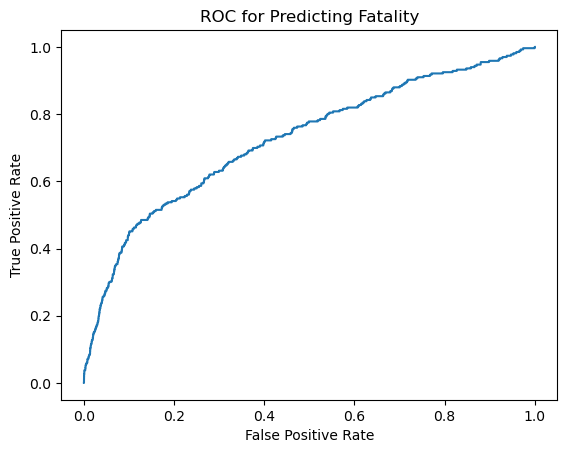

In [ ]:
#define metrics
fpr, tpr, _ = metrics.roc_curve(y_test,  y_predict)

#create ROC curve
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC for Predicting Fatality')
plt.show()

In [ ]:


model2_df = mvc_df[['BOROUGH', 'LATITUDE', 'LONGITUDE', 'CRASH HOUR']]
model2_df['TARGET'] = mvc_df['NUMBER OF PERSONS INJURED'] + mvc_df['NUMBER OF PERSONS KILLED']
model2_df = model2_df[model2_df['BOROUGH'] != 'UNKNOWN']
model2_df.dropna(inplace=True)
model2_df = pd.get_dummies(model2_df, columns = ['BOROUGH']) 

# Create X - assign independent variables, dependent variable, respectively
x = model2_df.loc[:, model2_df.columns != 'TARGET']

# Create Y - define the target
y = pd.DataFrame(model2_df['TARGET'])

# Splitting the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Initializing and fitting the model
model = DecisionTreeClassifier(max_depth=5, random_state=42)
model.fit(X_train, y_train)

# Making predictions
y_pred = model.predict(X_test)

# Printing accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

# Printing classification report for f1-score
print(classification_report(y_test, y_pred))

Accuracy: 0.705810009579784
              precision    recall  f1-score   support

         0.0       0.71      1.00      0.83     54521
         1.0       0.00      0.00      0.00     18219
         2.0       0.00      0.00      0.00      3085
         3.0       0.00      0.00      0.00       918
         4.0       0.00      0.00      0.00       315
         5.0       0.00      0.00      0.00       104
         6.0       0.00      0.00      0.00        46
         7.0       0.00      0.00      0.00        20
         8.0       0.00      0.00      0.00        11
         9.0       0.00      0.00      0.00         3
        10.0       0.00      0.00      0.00         2
        14.0       0.00      0.00      0.00         1
        23.0       0.00      0.00      0.00         1

    accuracy                           0.71     77246
   macro avg       0.05      0.08      0.06     77246
weighted avg       0.50      0.71      0.58     77246

